# Diabetes vs. Healthy Logistic Regression Modeling

In [1]:
import pandas as pd
import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import yellowbrick
#sn.set(rc={'figure.figsize':(10,5)})

In [2]:
data = pd.read_csv('total_cleaned.csv')
data.head

<bound method NDFrame.head of         DIABETE3  _BMI5  SMOKE100  CVDSTRK3  _TOTINDA  HLTHPLN1  MEDCOST  \
0            0.0   19.0       1.0       0.0       0.0       1.0      0.0   
1            0.0   19.0       1.0       0.0       0.0       1.0      0.0   
2            0.0   35.0       1.0       0.0       0.0       1.0      1.0   
3            1.0   43.0       1.0       0.0       1.0       1.0      0.0   
4            0.0   22.0       0.0       0.0       1.0       0.0      1.0   
...          ...    ...       ...       ...       ...       ...      ...   
528789       0.0   27.0       0.0       0.0       0.0       1.0      1.0   
528790       2.0   25.0       0.0       0.0       0.0       1.0      0.0   
528791       0.0   23.0       0.0       1.0       0.0       1.0      1.0   
528792       0.0   42.0       0.0       0.0       1.0       1.0      0.0   
528793       0.0   45.0       0.0       0.0       0.0       1.0      0.0   

        GENHLTH  MENTHLTH  PHYSHLTH  SEX  _AGEG5YR  EDUCA

In [3]:
data = data.rename(
    columns = 
    {'DIABETE3':'Diabetes_012',
     '_BMI5':'BMI',
     'SMOKE100':'Smoker',
     'CVDSTRK3':'Stroke',
     '_TOTINDA':'PhysActivity',
     'HLTHPLN1':'AnyHealthcare',
     'MEDCOST':'NoDocbcCost',
     'GENHLTH':'GenHlth',
     'MENTHLTH':'MentHlth',
     'PHYSHLTH':'PhysHlth',
     'SEX':'Sex',
     '_AGE5YR':'Age',
     'EDUCA':'Education',
     'INCOME2':'Income',
     'MARITAL':'Marital',
     'POORHLTH':'PoorHlth',
     'CVDINFR4':'HeartAttack',
     '_RFHYPE5':'HighBP',
     '_AGEG5YR':'Age'
    }
)

In [4]:
data.isna().sum()

Diabetes_012     0
BMI              0
Smoker           0
Stroke           0
PhysActivity     0
AnyHealthcare    0
NoDocbcCost      0
GenHlth          0
MentHlth         0
PhysHlth         0
Sex              0
Age              0
Education        0
Income           0
Marital          0
PoorHlth         0
HeartAttack      0
HighBP           0
dtype: int64

In [5]:
data.dtypes

Diabetes_012     float64
BMI              float64
Smoker           float64
Stroke           float64
PhysActivity     float64
AnyHealthcare    float64
NoDocbcCost      float64
GenHlth          float64
MentHlth         float64
PhysHlth         float64
Sex              float64
Age              float64
Education        float64
Income           float64
Marital          float64
PoorHlth         float64
HeartAttack      float64
HighBP           float64
dtype: object

## Variable of Interest

<AxesSubplot: >

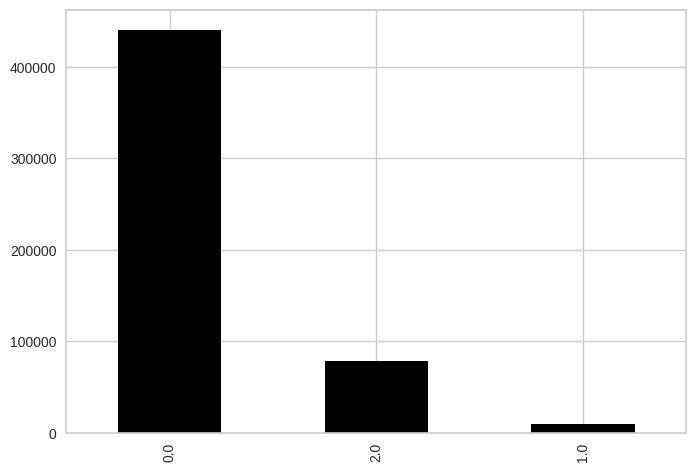

In [6]:
data['Diabetes_012'].value_counts().plot(kind='bar', color='black')

## Selecting Outcomes of Interest

We can see that we have quite an unbalanced dataset. However, because these samples are not evenly distributed in our population, we will leverage different approaches later in our modeling to accommodate for this imbalance.

In [7]:
data.groupby(['Diabetes_012']).size()

Diabetes_012
0.0    440607
1.0      9930
2.0     78257
dtype: int64

In [8]:
# remove prediabetes class
data = data[(data.Diabetes_012 != 1)]

data.groupby(['Diabetes_012']).size()

Diabetes_012
0.0    440607
2.0     78257
dtype: int64

In [9]:
data['Diabetes_012'] = data['Diabetes_012'].replace({2:1})

## Continuous Numerical Predictors

We have 1 continuous numerical predictor - BMI. 

### BMI

<AxesSubplot: title={'center': 'BMI'}, ylabel='Frequency'>

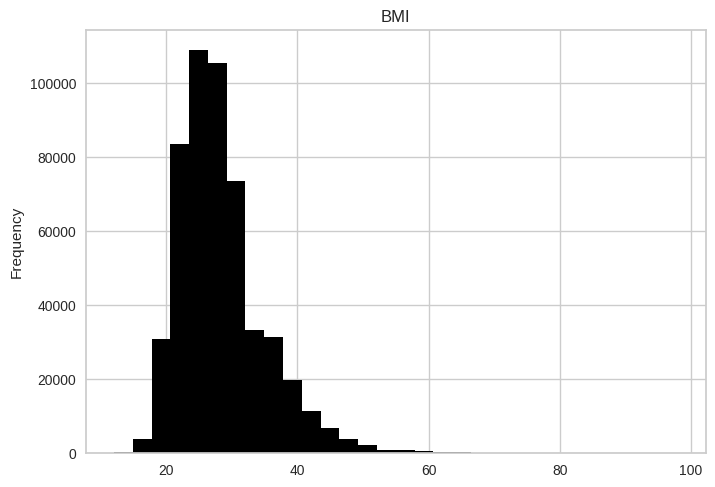

In [10]:
data['BMI'].plot(kind='hist', color='black',bins=30, title='BMI')

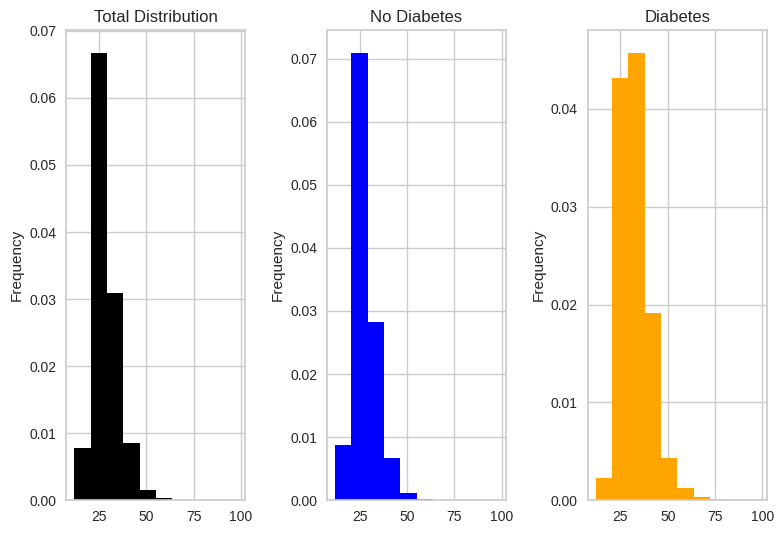

In [11]:
var = 'BMI'

fig, axes = plt.subplots(nrows=1, ncols=3)
data[var].plot(ax=axes[0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[1],kind='hist',color='blue', density=True).set_title("No Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[2],kind='hist',color='orange', density=True).set_title("Diabetes")
plt.tight_layout()

In [12]:
data[var].groupby(data['Diabetes_012']).describe()

,count,mean,std,min,25%,50%,75%,max
Diabetes_012,,,,,,,,
0.0,440607.0,27.720438,6.351685,12.0,23.0,27.0,31.0,98.0
1.0,78257.0,32.522254,7.780586,12.0,27.0,31.0,37.0,98.0


In [13]:
# One-Way ANOVA - Test of Variance Between Groups
nodiab = data.query('Diabetes_012 == 0')[var]
diab = data.query('Diabetes_012 == 1')[var]
import scipy.stats as stats
stats.ttest_ind(nodiab,diab,equal_var=True)

Ttest_indResult(statistic=-187.92018567819431, pvalue=0.0)

<AxesSubplot: xlabel='Diabetes_012', ylabel='BMI'>

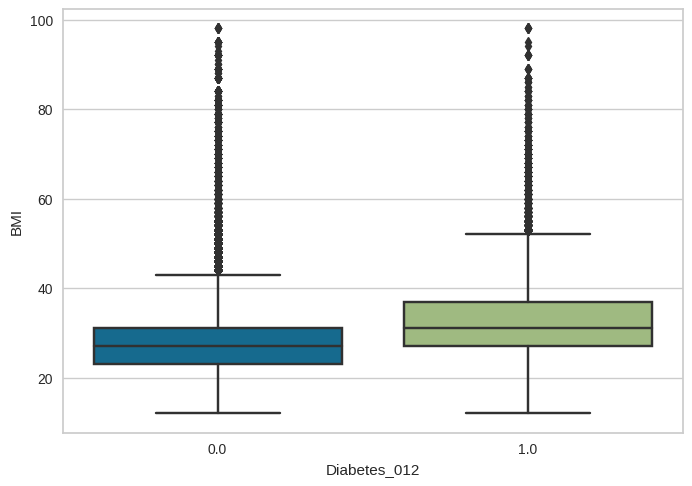

In [14]:
sn.boxplot(x='Diabetes_012', y=var, data=data)

Let's transform this variable - there are quite a few outliers which might make convergence difficult later. Let's transform this to mirror the categories used in the field.

In [15]:
data['BMI'].mask(data['BMI'] < 18.5, 0, inplace=True)
data['BMI'].mask((data['BMI'] >= 18.5) & (data['BMI'] <= 24.9), 1, inplace=True)
data['BMI'].mask((data['BMI'] >= 25) & (data['BMI'] <= 29.9), 2, inplace=True)
data['BMI'].mask((data['BMI'] >= 30) & (data['BMI'] <= 34.9), 3, inplace=True)
data['BMI'].mask((data['BMI'] >= 35) & (data['BMI'] <= 39.9), 4, inplace=True)
data['BMI'].mask((data['BMI'] >= 40), 5, inplace=True)

Text(0.5, 1.0, 'Diabetes')

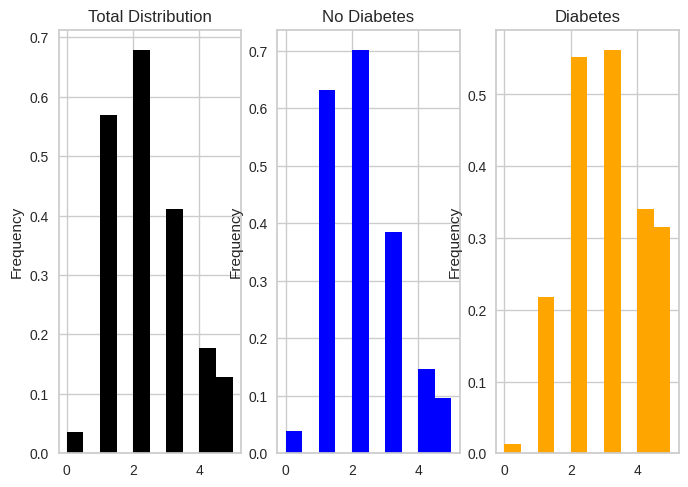

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3)
data[var].plot(ax=axes[0],kind='hist',color='black', density=True).set_title("Total Distribution")
data.query('Diabetes_012 == 0')[var].plot(ax=axes[1],kind='hist',color='blue', density=True).set_title("No Diabetes")
data.query('Diabetes_012 == 1')[var].plot(ax=axes[2],kind='hist',color='orange', density=True).set_title("Diabetes")


## Categorical Predictors
The rest of our predictors are categorical or binary. 
This requires a different approach than what we can do with a continous valued predictor.


HighBP

HighChol

CholCheck

BMI

Smoker

Stroke

HeartDiseaseorAttack

PhysActivity

Fruits

Veggies

HvyAlcoholConsump

AnyHealthcare

NoDocbcCost

GenHlth

DiffWalk

Sex 

Age    

Education

Income                  


In [17]:
def var_hist(var, data,fig,w,h):
    
    plt.tight_layout()
    gs = fig.add_gridspec(5,2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[2, :])
    ax6 = fig.add_subplot(gs[3, :])
    ax7 = fig.add_subplot(gs[4, 0])
    ax8 = fig.add_subplot(gs[4, 1])
    plt.tight_layout()
    fig.set_figwidth(w)
    fig.set_figheight(h)
    fig.suptitle(var, fontsize=14)
    data[var].plot(ax=ax1,kind='hist',color='black', density=True).set_title("Total Distribution")
    data.query('Diabetes_012 == 0')[var].plot(ax=ax2,kind='hist',color='blue', density=True).set_title("No Diabetes")
    data.query('Diabetes_012 == 1')[var].plot(ax=ax3,kind='hist',color='orange', density=True).set_title("Diabetes")
    desc = data[var].groupby(data['Diabetes_012']).describe()
    desc.insert(0, 'Class', desc.index)
    table = desc 
    cell_text = []
    for row in range(len(table)):
        cell_text.append(round(table.iloc[row],2))
    table = ax5.table(cellText=cell_text, colLabels=table.columns, loc=ax5)
    ax5.axis('off')
    table.set_fontsize(10)
    ax5.set_title(var + " - descriptive statistics")
    plt.tight_layout()
    crosstab = pd.crosstab(data[var],data['Diabetes_012'])
    chi2, p, dof, expected = stats.chi2_contingency(crosstab)
    ct_data = {'Chi-square: ':  [chi2],
            'p-value: ': [p],
            'DOF: ': [dof]}
    df = pd.DataFrame(ct_data)
    cell_text_chi = []
    for row in range(len(df)):
        cell_text_chi.append(df.iloc[row])
    table_chi = ax6.table(cellText=cell_text_chi,colLabels=df.columns, loc=ax6)
    ax6.axis('off')
    table_chi.set_fontsize(10)
    ax6.set_title(var + " - Chi Square Test")
    plt.tight_layout()
    act = pd.DataFrame(crosstab)
    act_cell_text = []
    for row in range(len(act)):
        act_cell_text.append(act.iloc[row])
    table_act = ax7.table(cellText=act_cell_text,colLabels=act.columns, loc=ax7)
    ax7.axis('tight')
    ax7.axis('off')
    table_act.set_fontsize(10)
    ax7.set_title("Chi Square - Actual Frequencies")
    plt.tight_layout()
    exp = pd.DataFrame(expected)
    exp_cell_text = []
    for row in range(len(exp)):
        exp_cell_text.append(exp.iloc[row])
    table_exp = ax8.table(cellText=exp_cell_text,colLabels=exp.columns, loc=ax8)
    ax8.axis('off')
    table_exp.set_fontsize(10)
    ax8.set_title("Chi Square - Expected Frequencies")

In [18]:
from sklearn.feature_selection import chi2

X = data.drop('Diabetes_012',axis=1)
y = data['Diabetes_012']

chi_scores = chi2(X,y)
chi_scores

(array([2.10397986e+04, 5.93361856e+02, 7.76830737e+03, 2.29243155e+03,
        1.16639712e+02, 7.96679401e+00, 2.10586362e+04, 6.81679725e+02,
        2.68233507e+03, 1.90929462e+02, 4.19476678e+04, 1.71448913e+03,
        1.15622066e+04, 3.74991150e+02, 2.25674953e+03, 1.49755315e+04,
        2.64578610e+04]),
 array([0.00000000e+000, 4.65223235e-131, 0.00000000e+000, 0.00000000e+000,
        3.44253486e-027, 4.76432473e-003, 0.00000000e+000, 2.88166606e-150,
        0.00000000e+000, 1.99274668e-043, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000, 1.53279959e-083, 0.00000000e+000, 0.00000000e+000,
        0.00000000e+000]))

In [19]:
p_values = pd.DataFrame(chi_scores[1],index = X.columns)
print(p_values)
print("p-value greater than 0.05:")
for p in p_values.index:
    val = p_values.loc[p]
    if val.loc[0] > 0.05:
        print(val.name)

                           0
BMI             0.000000e+00
Smoker         4.652232e-131
Stroke          0.000000e+00
PhysActivity    0.000000e+00
AnyHealthcare   3.442535e-27
NoDocbcCost     4.764325e-03
GenHlth         0.000000e+00
MentHlth       2.881666e-150
PhysHlth        0.000000e+00
Sex             1.992747e-43
Age             0.000000e+00
Education       0.000000e+00
Income          0.000000e+00
Marital         1.532800e-83
PoorHlth        0.000000e+00
HeartAttack     0.000000e+00
HighBP          0.000000e+00
p-value greater than 0.05:


In [20]:
#data = data.drop(columns=['AnyHealthcare','Sex','MentHlth'],axis=1)
var_list = list(data.drop('Diabetes_012', axis=1).columns)
var_idx = -1

### BMI

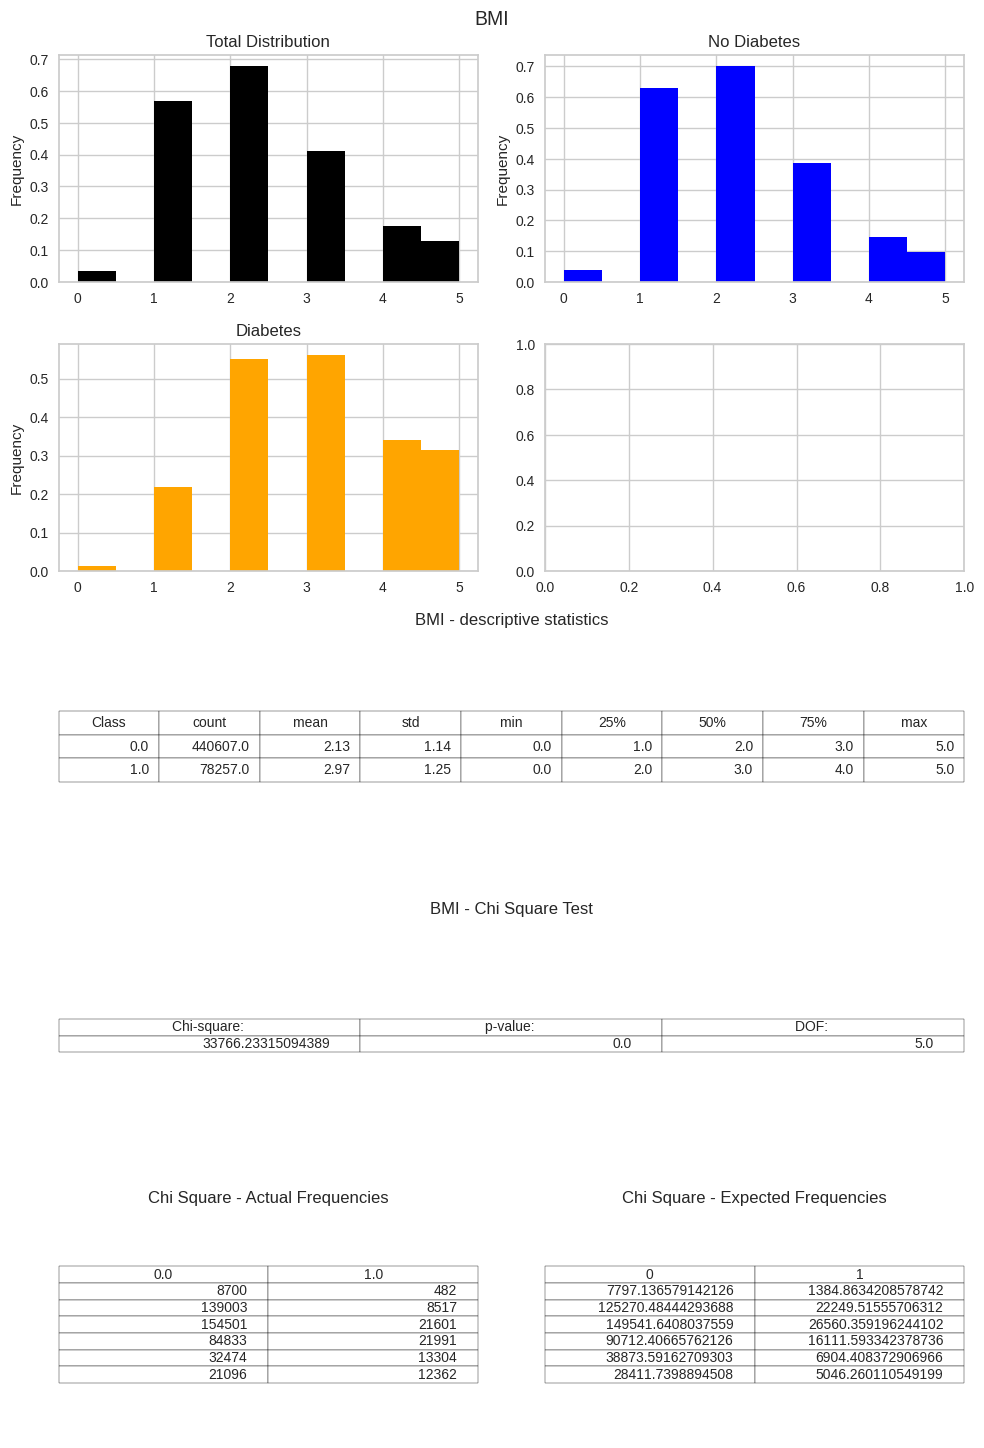

In [21]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Smoker

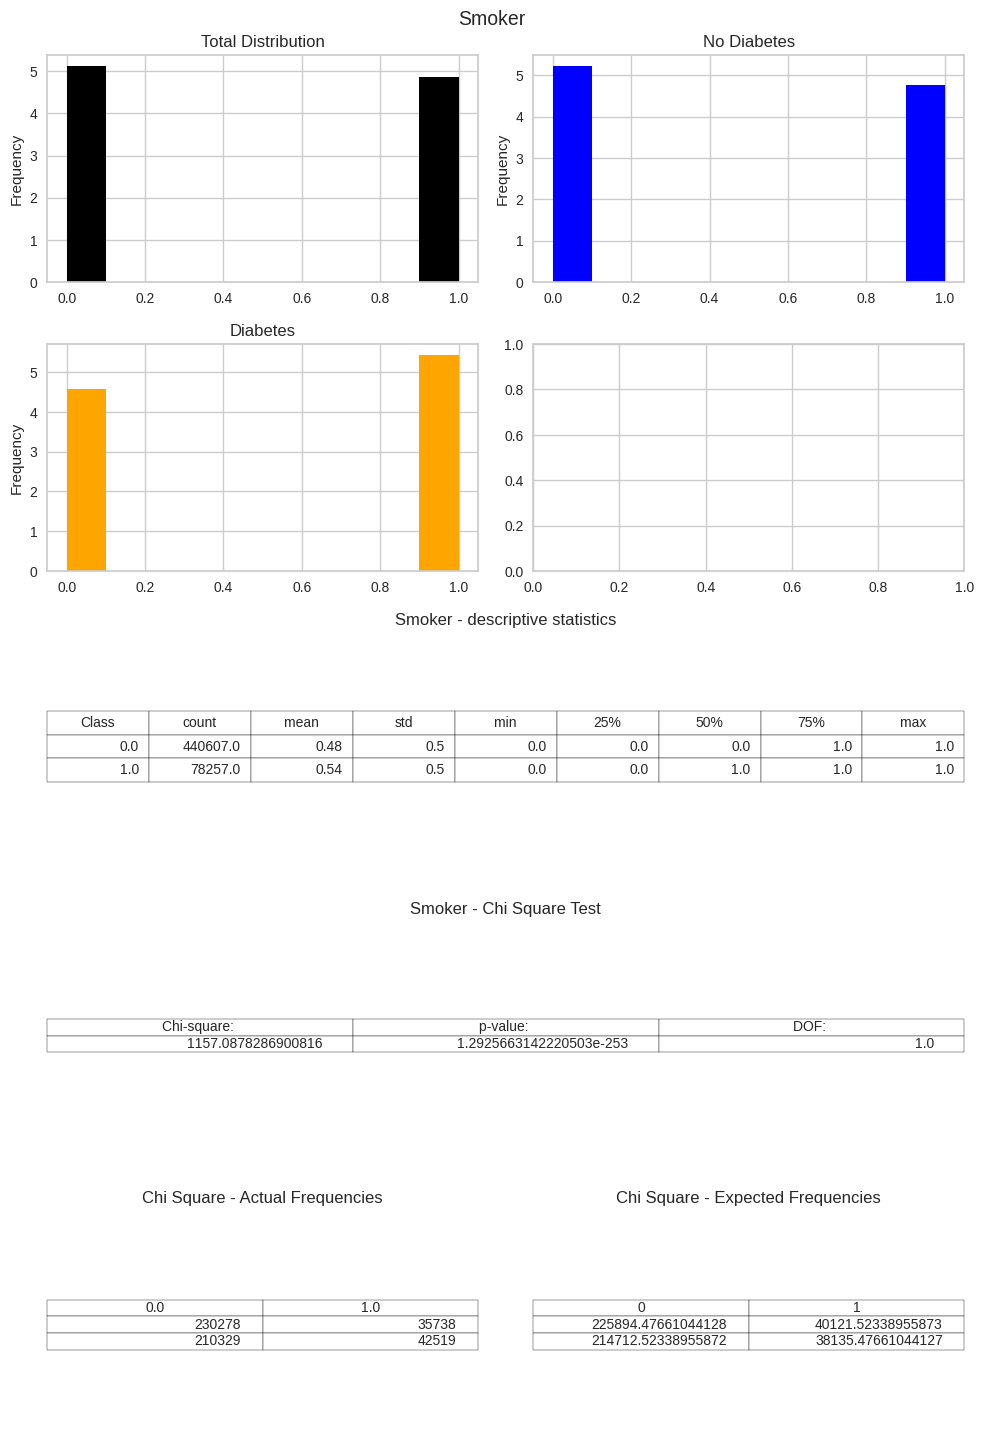

In [22]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Stroke

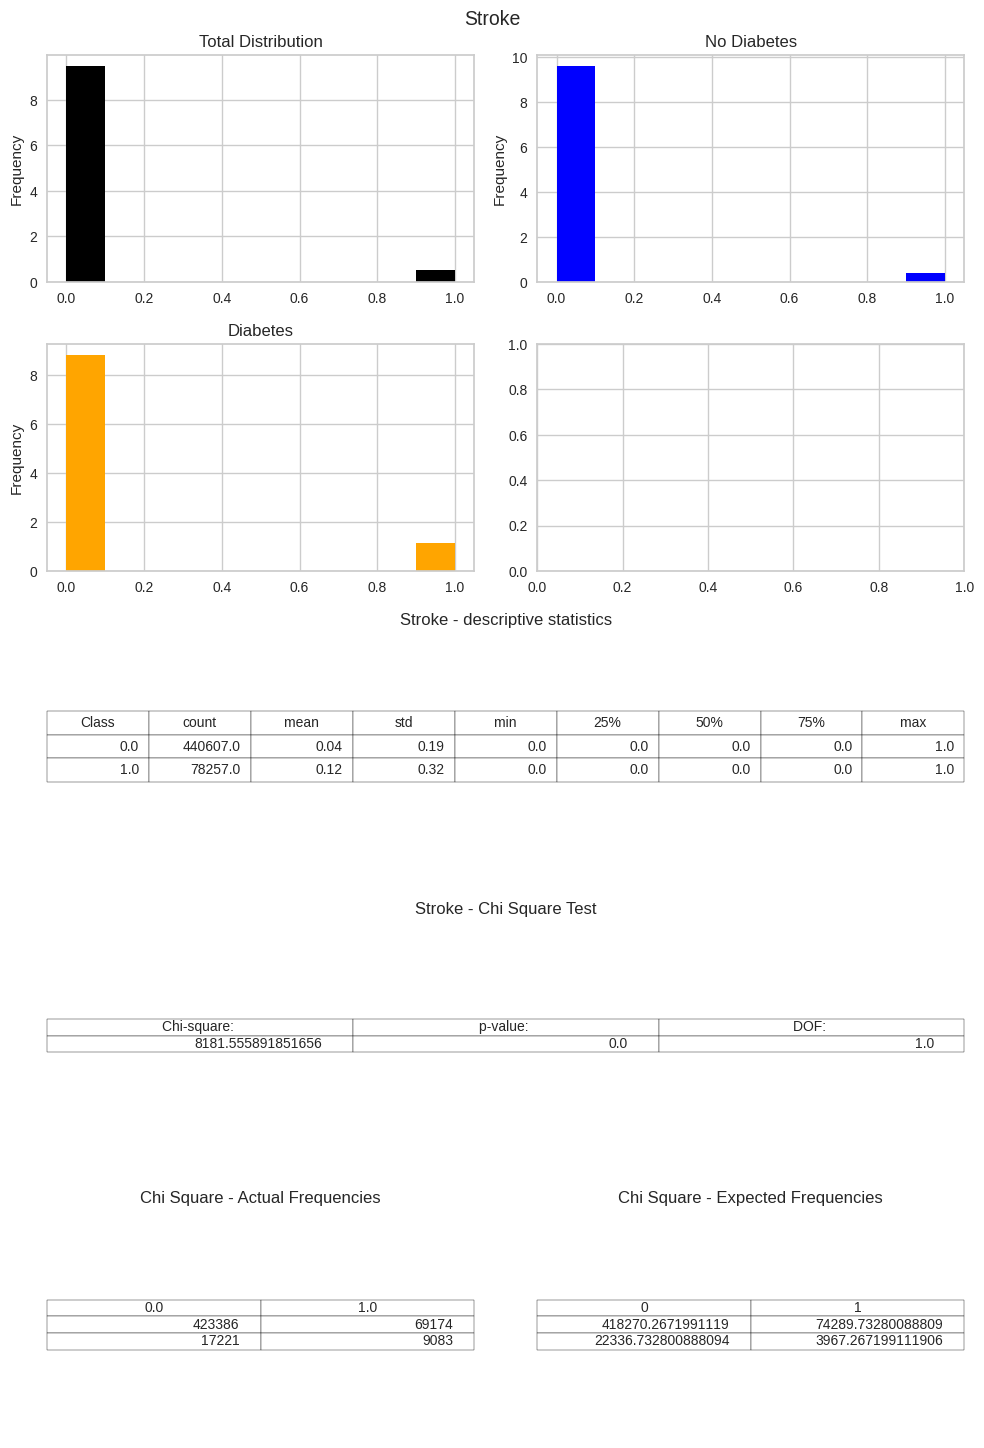

In [23]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Physical Activity

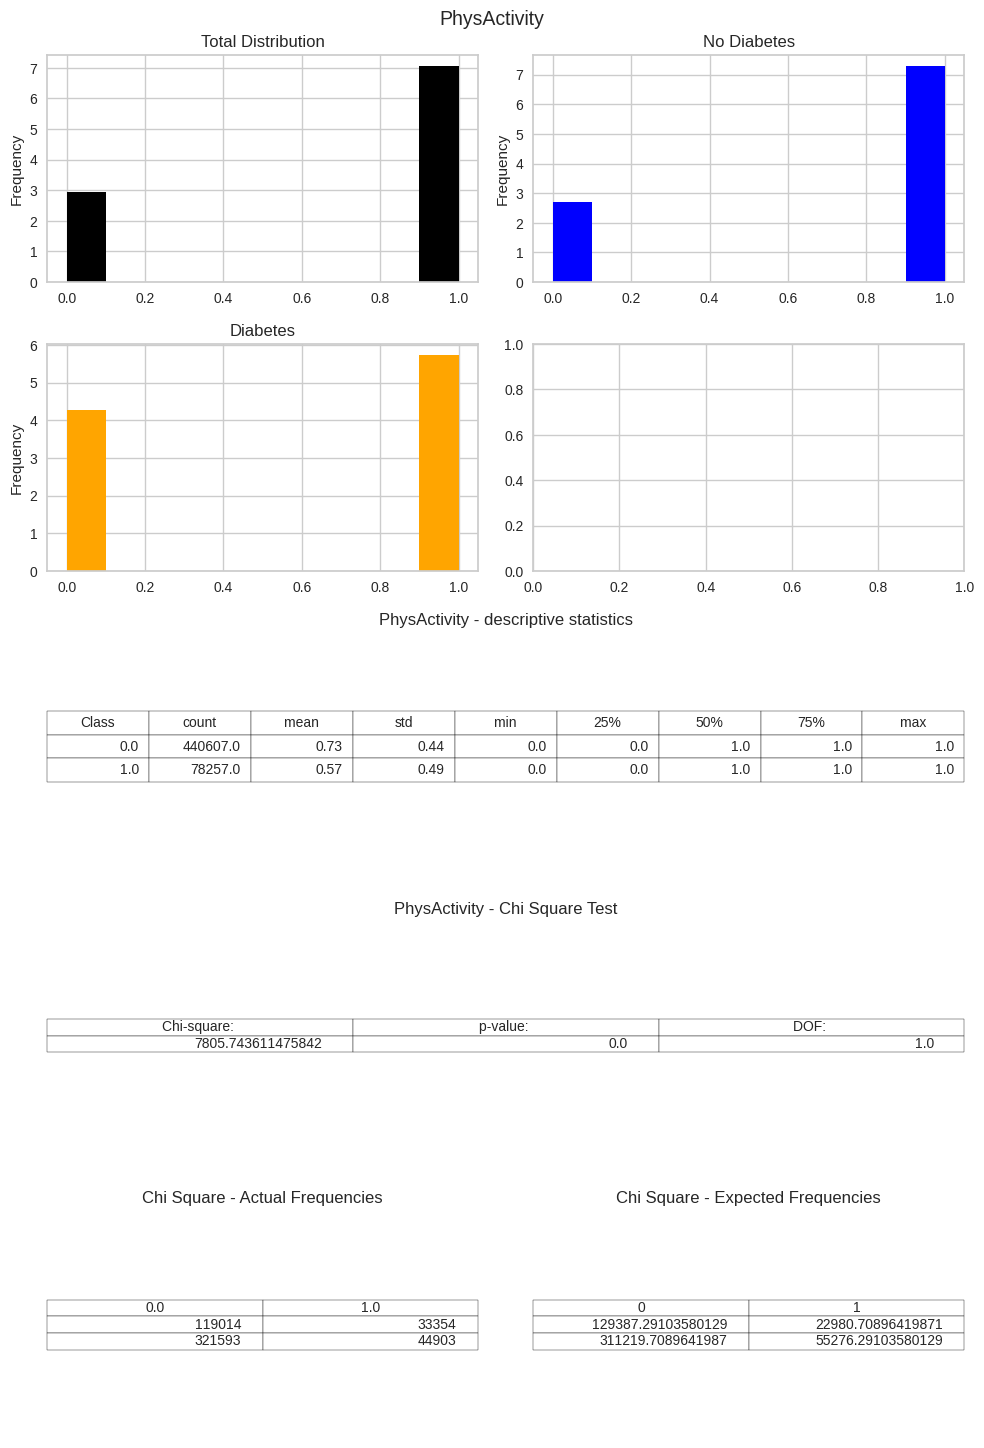

In [24]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### No Doctor Because of Cost

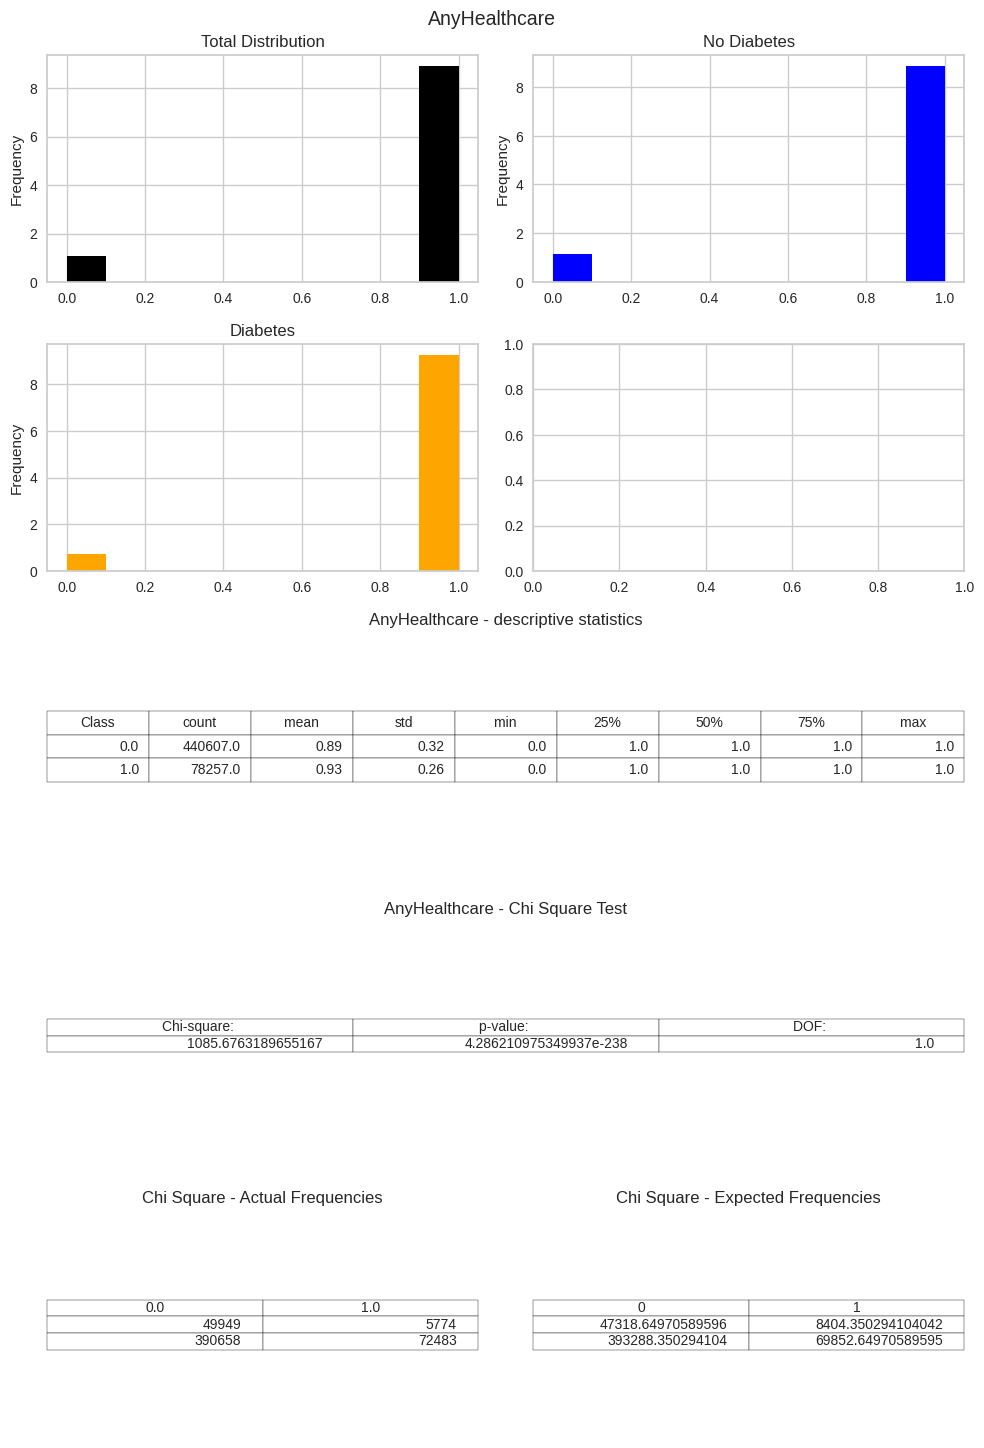

In [25]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### General Health

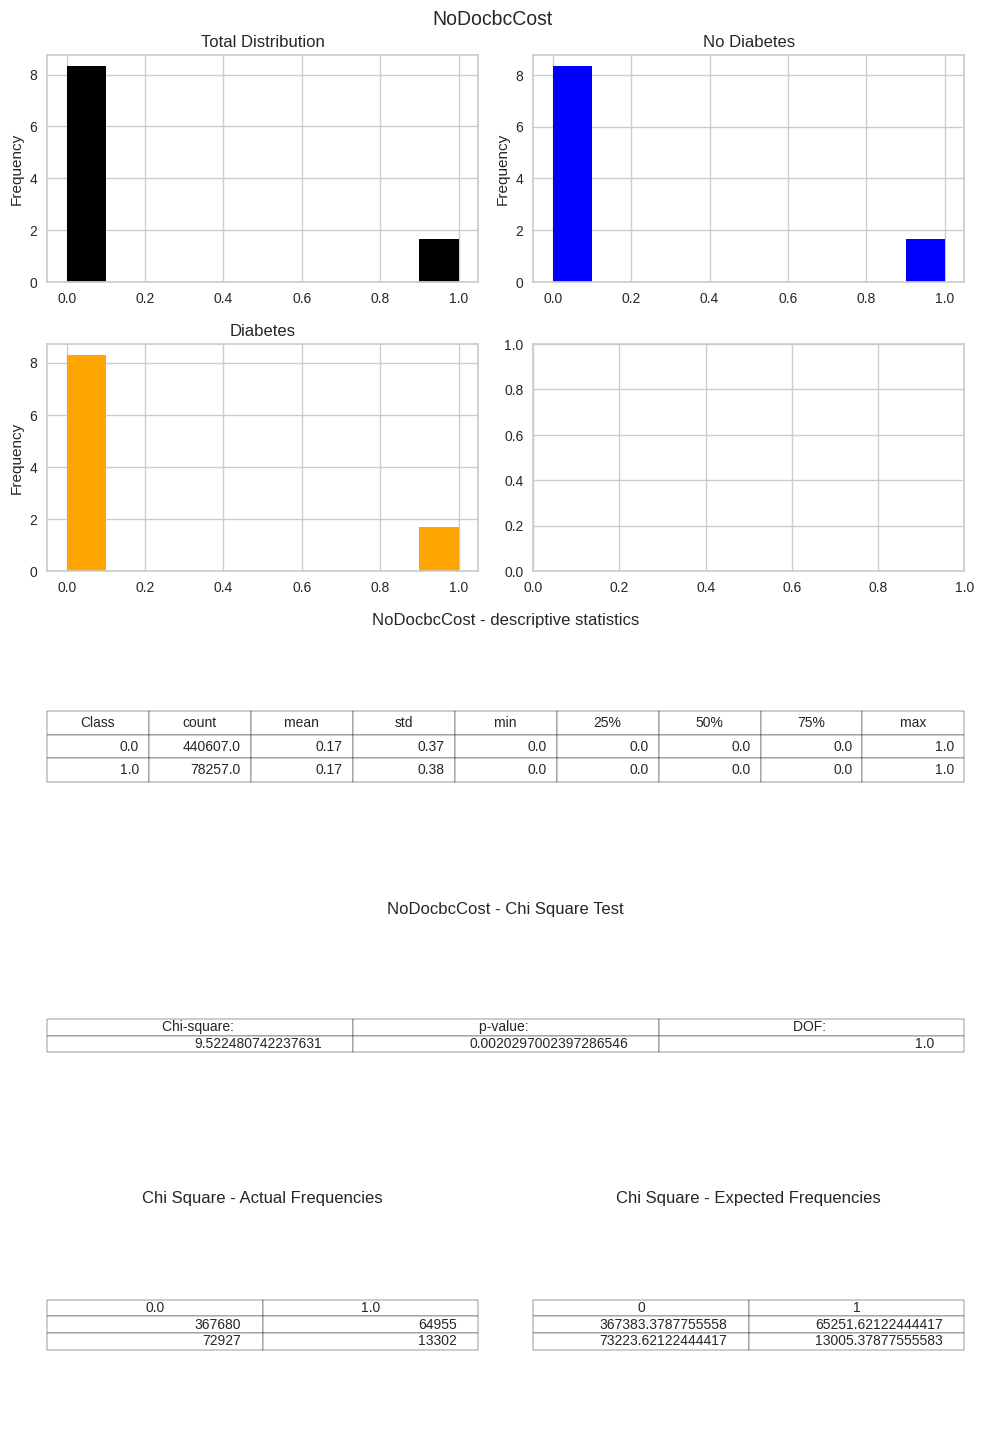

In [26]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Physical Health

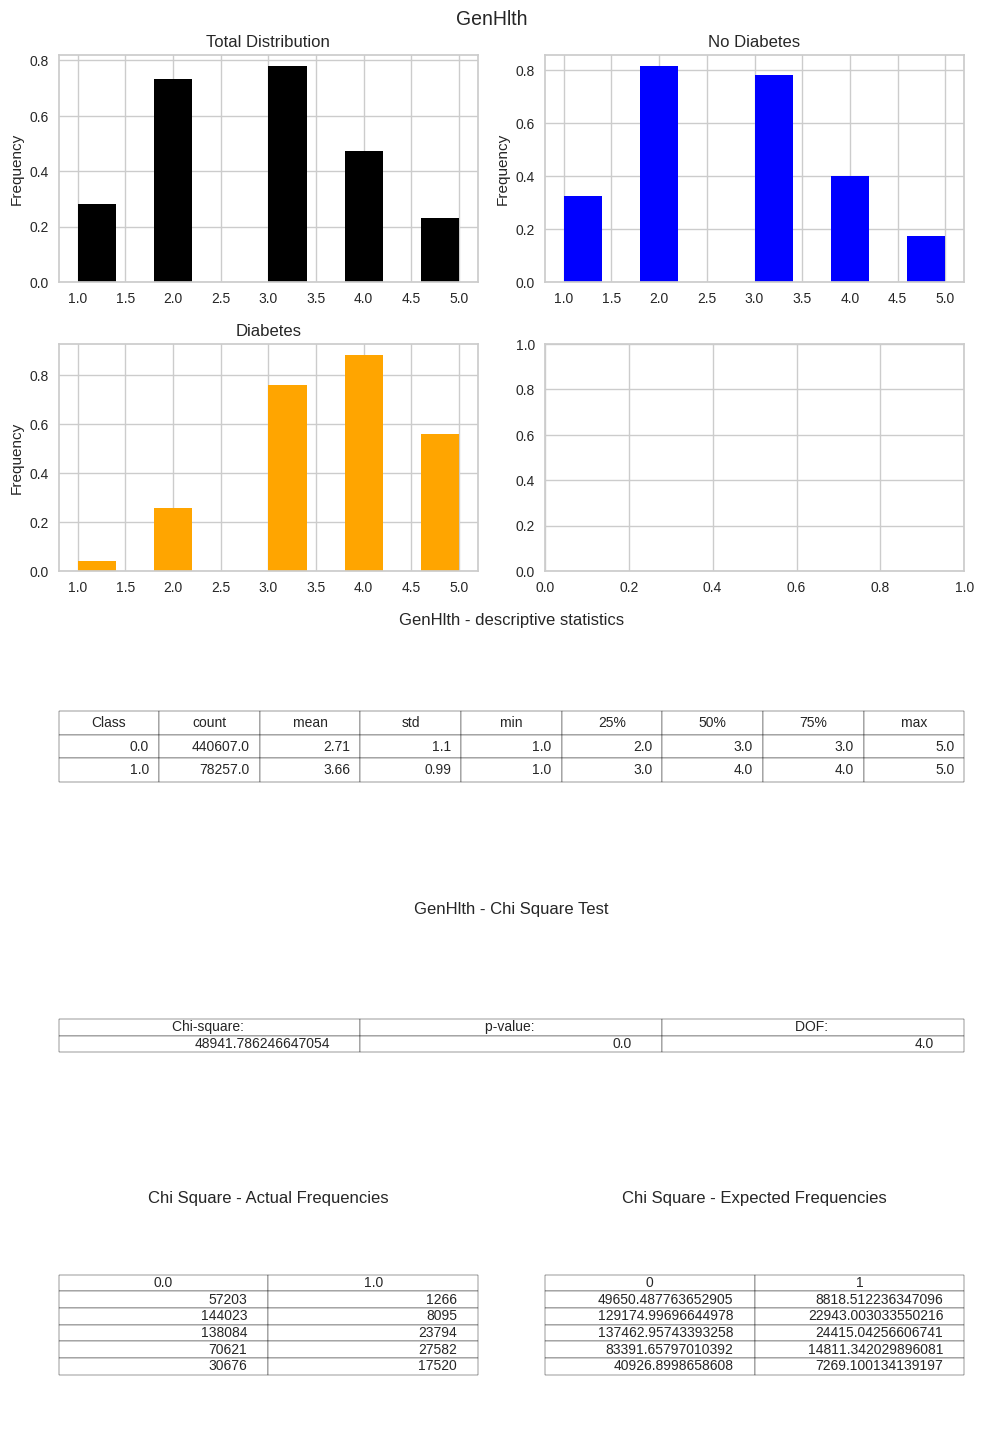

In [27]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Age

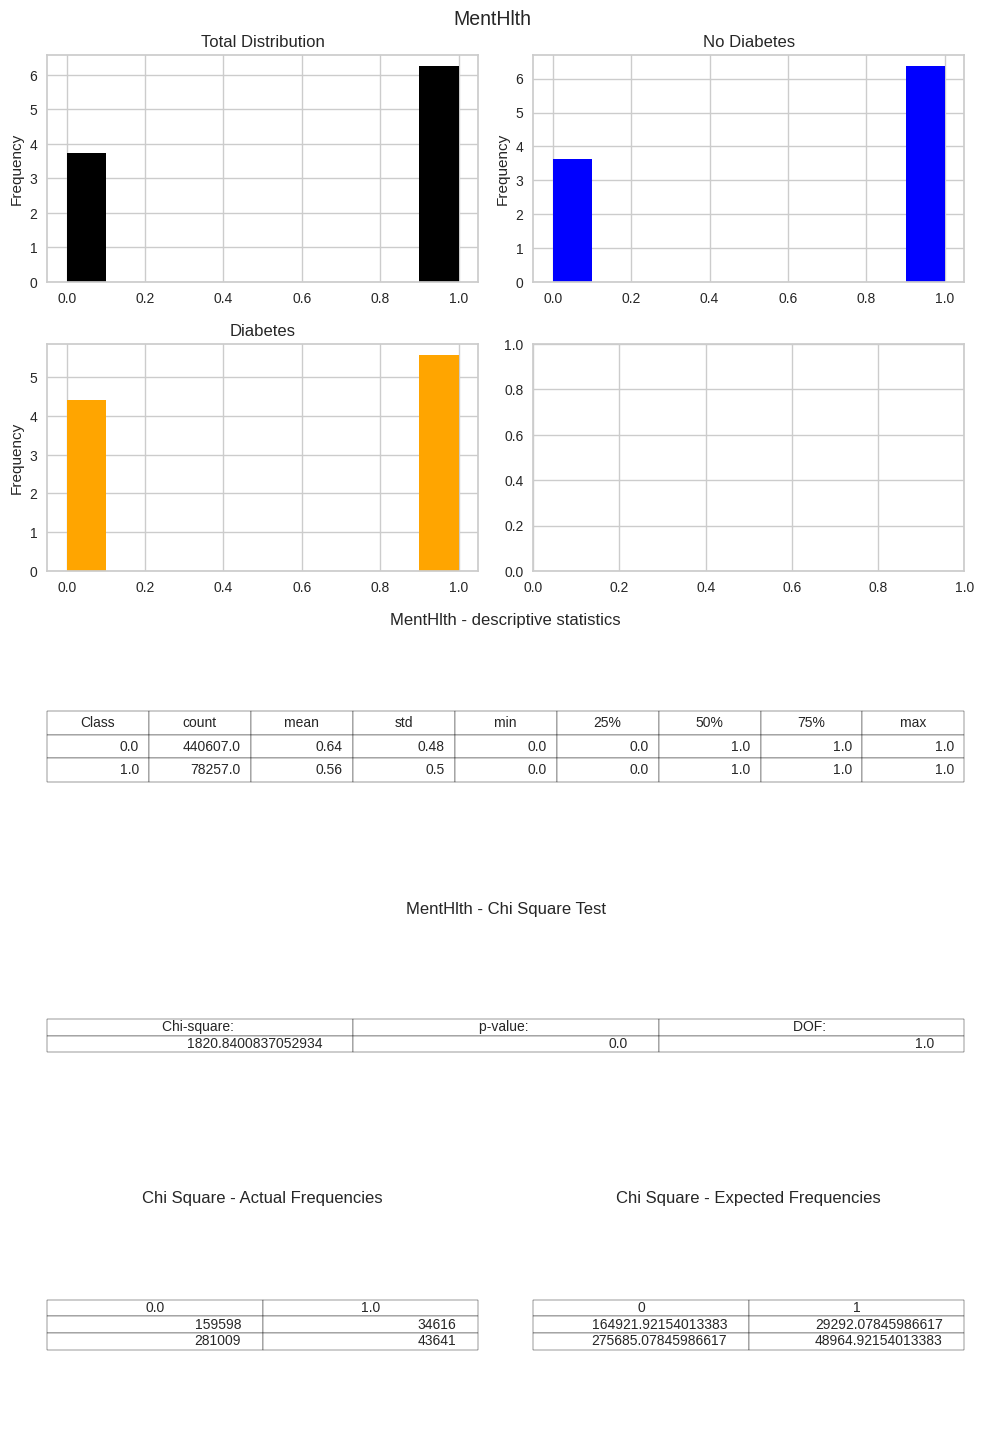

In [28]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Education

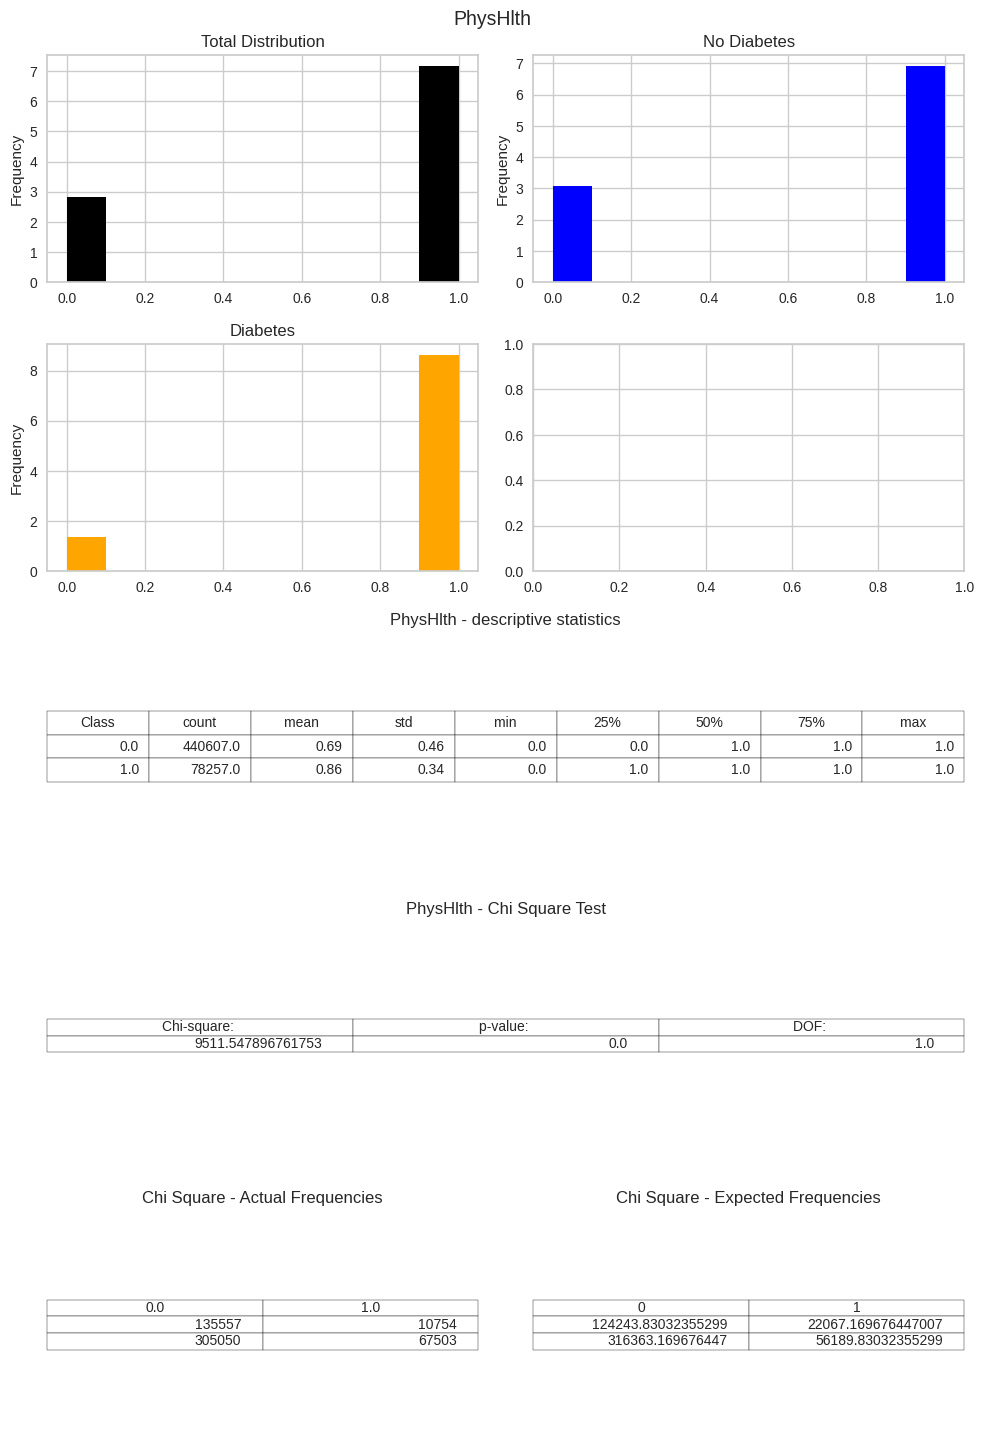

In [29]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Income

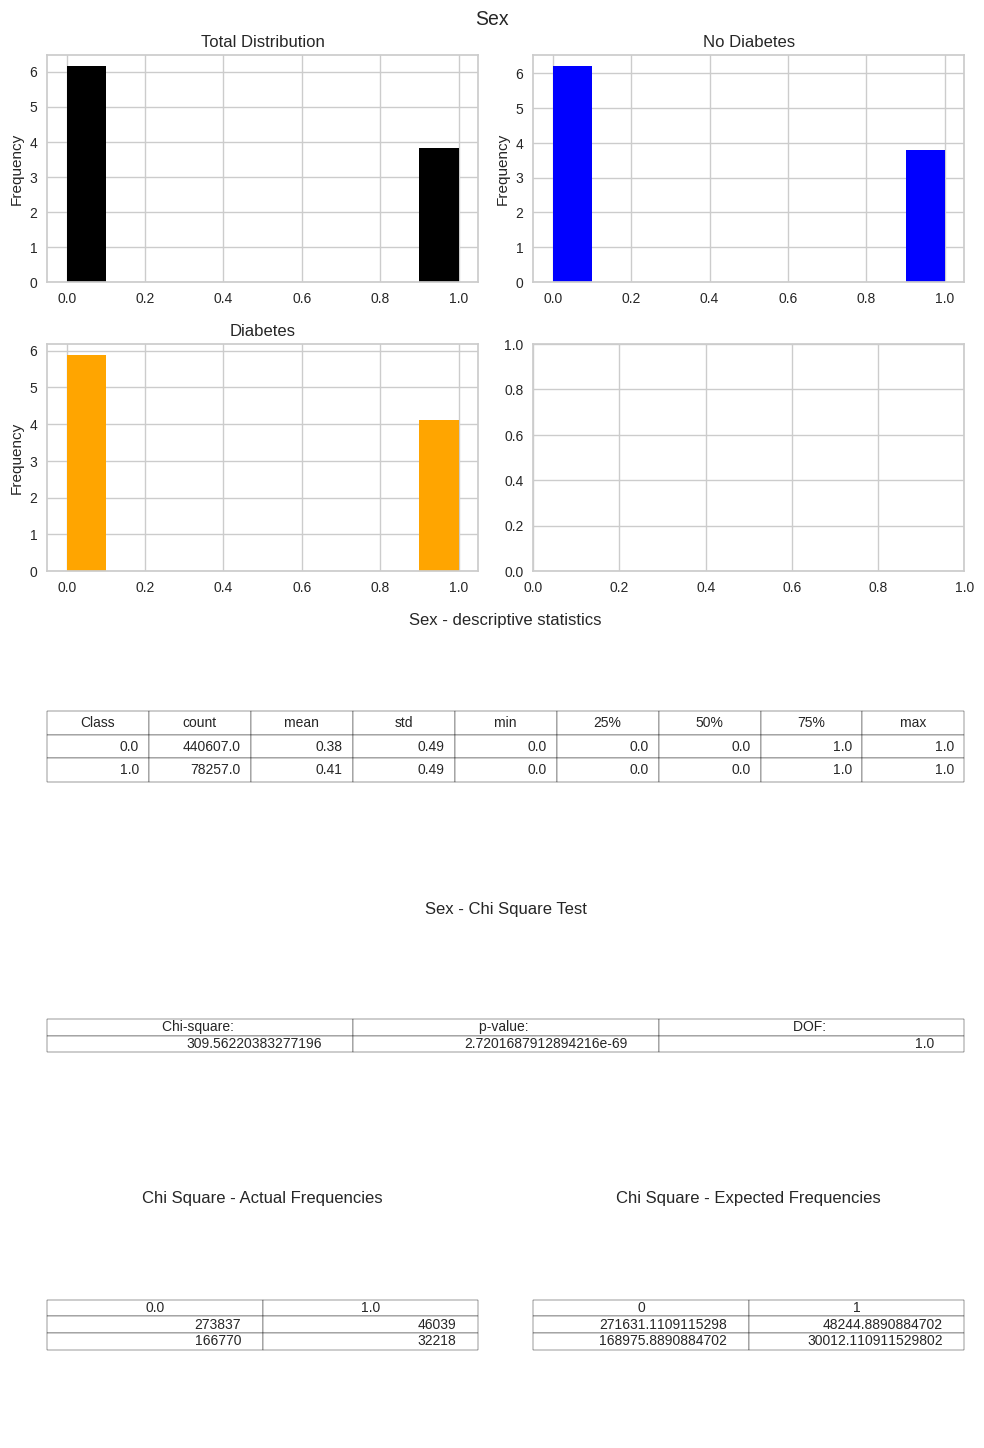

In [30]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Marital

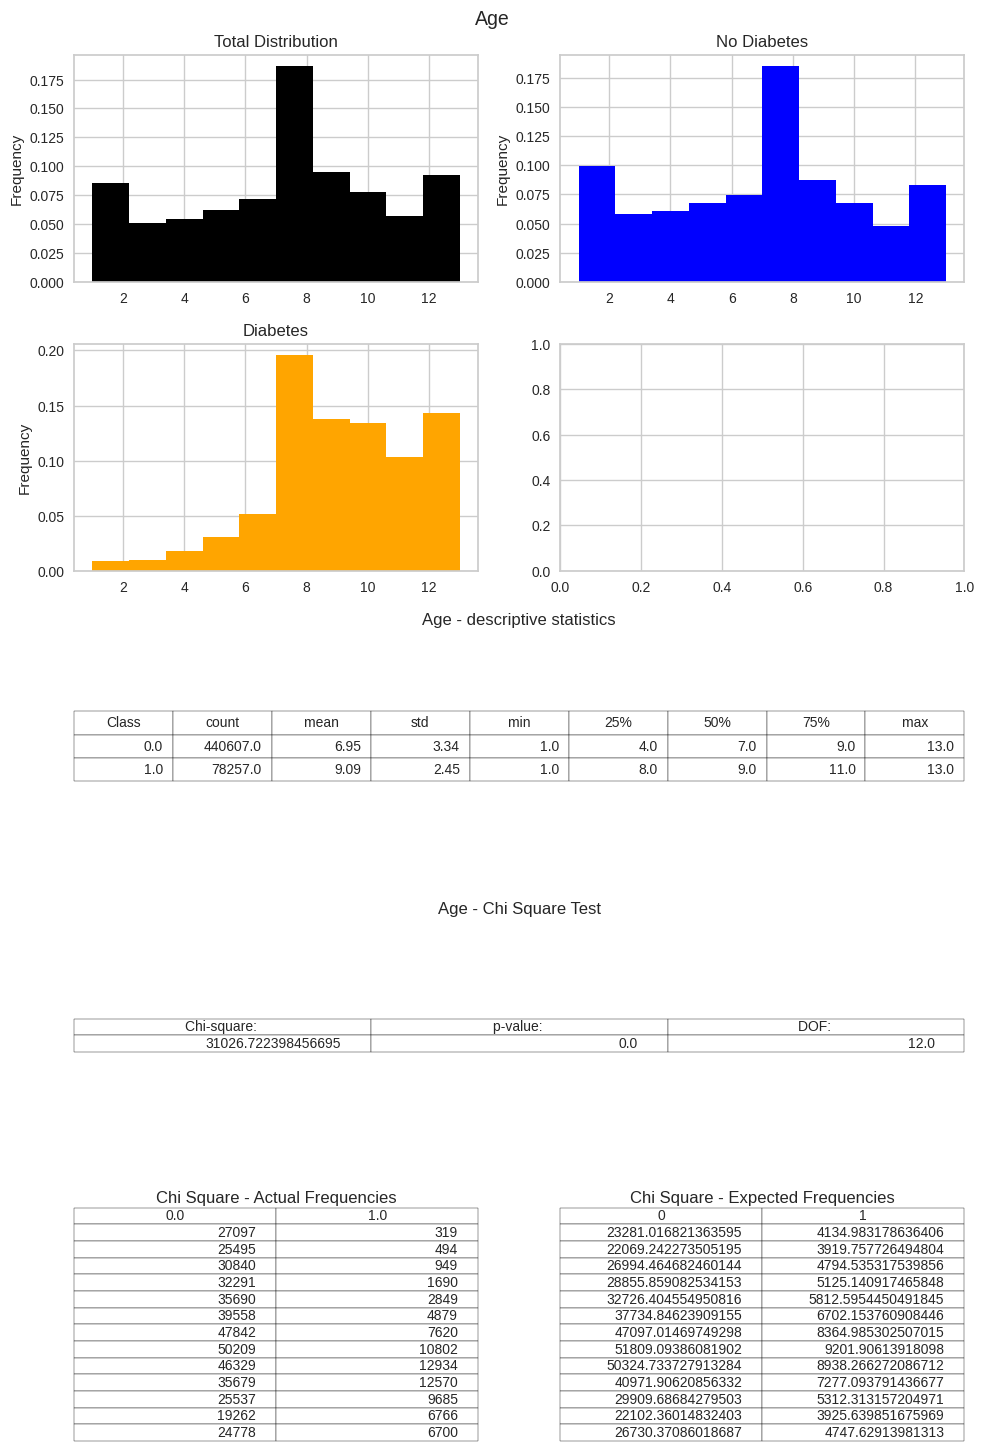

In [31]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Poor Health

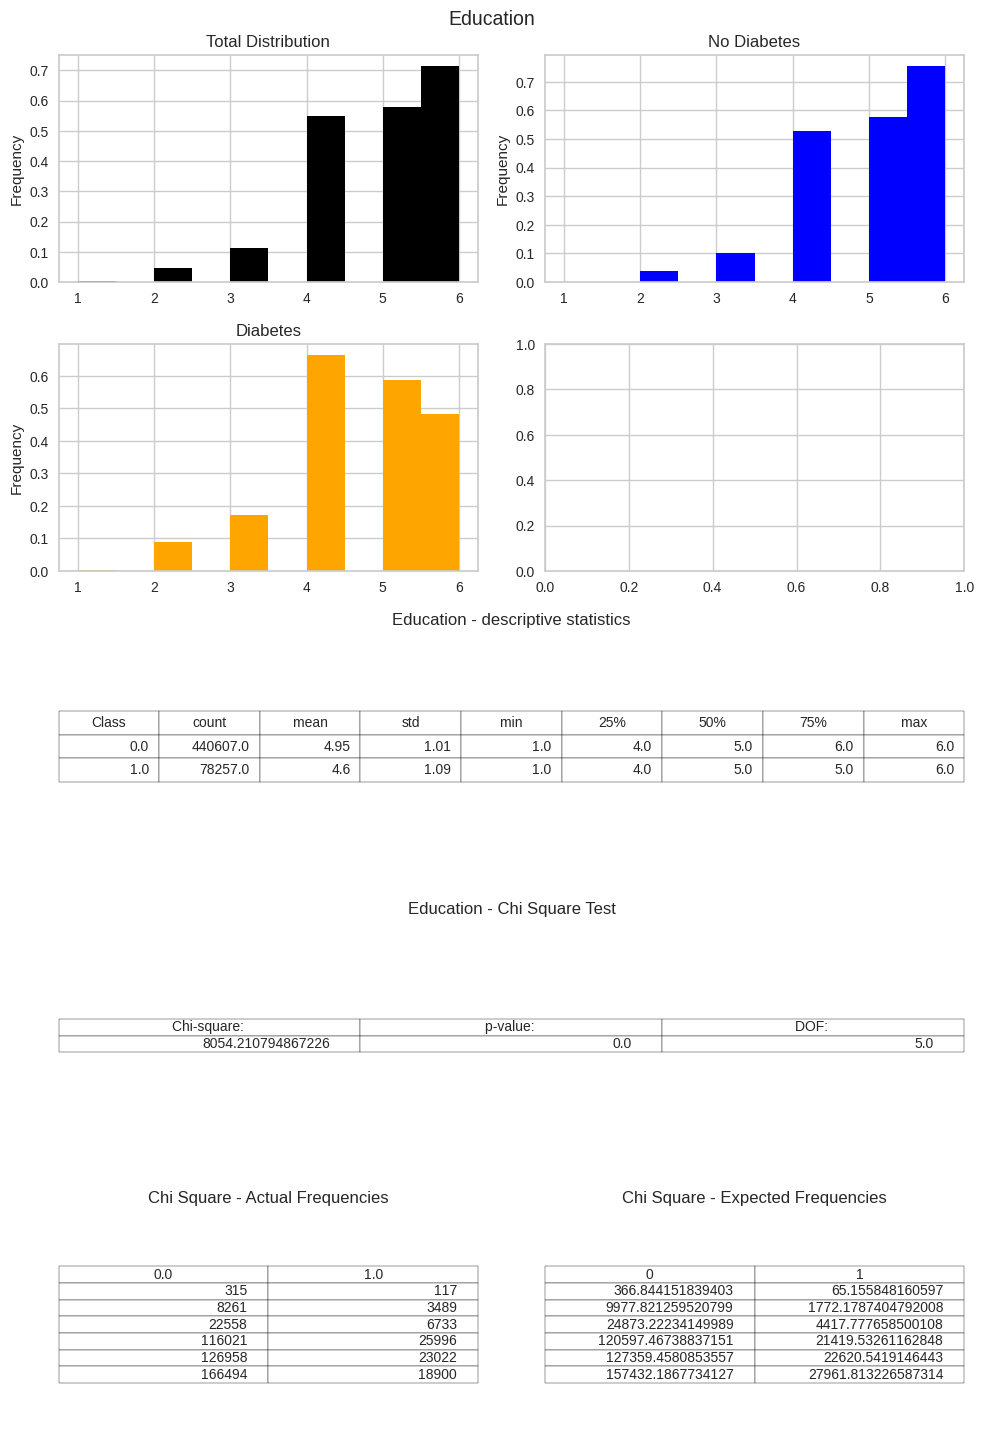

In [32]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### Heart Attack

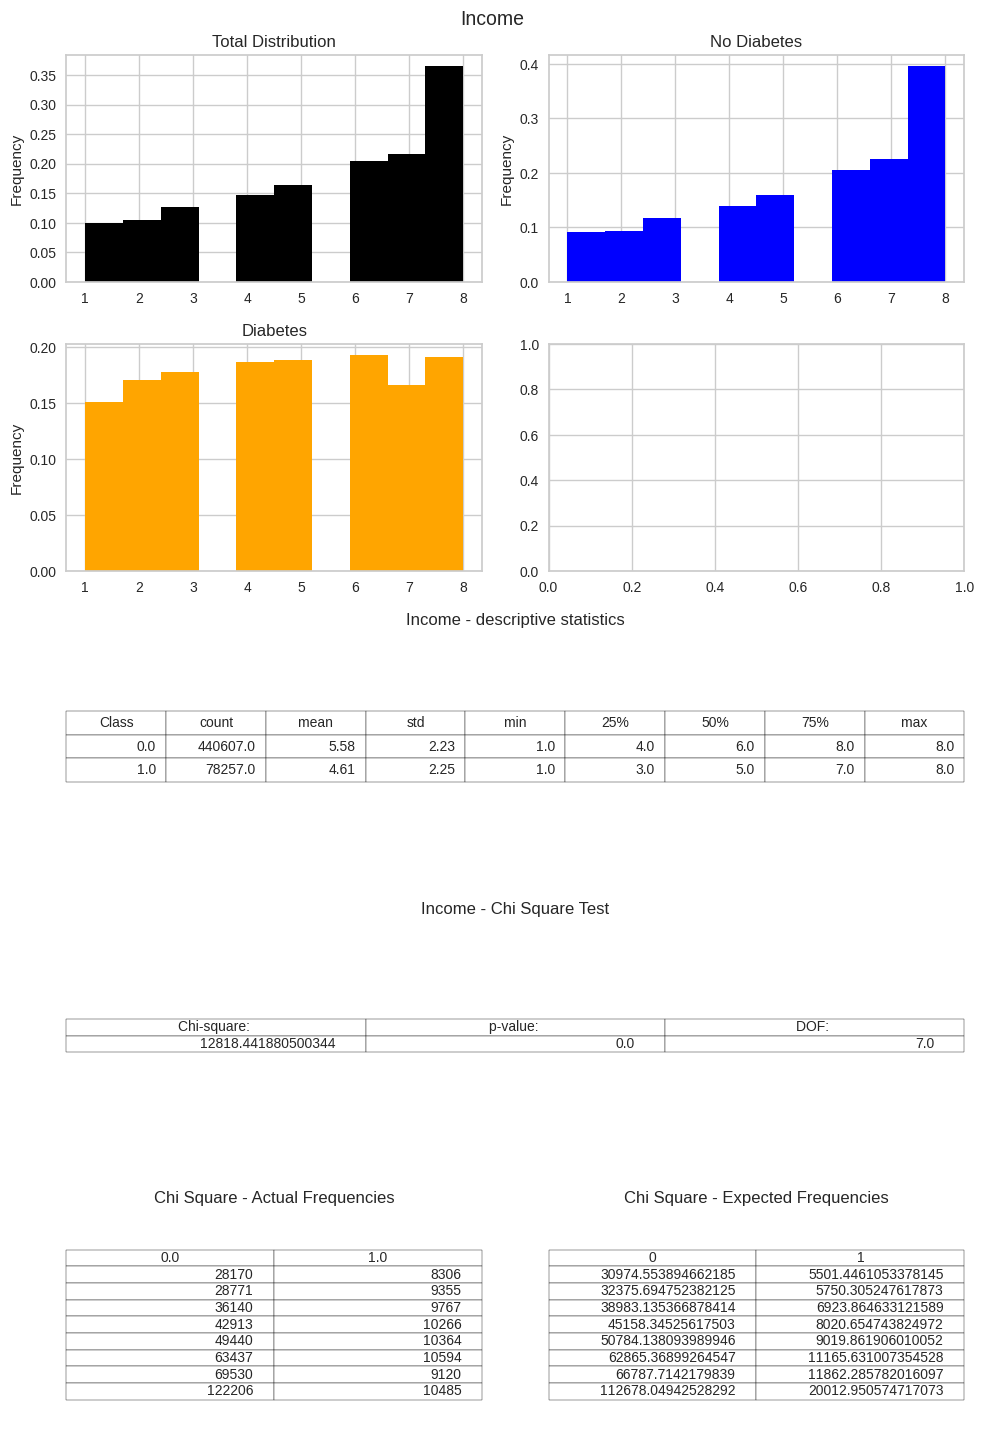

In [33]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

### High Blood Pressure

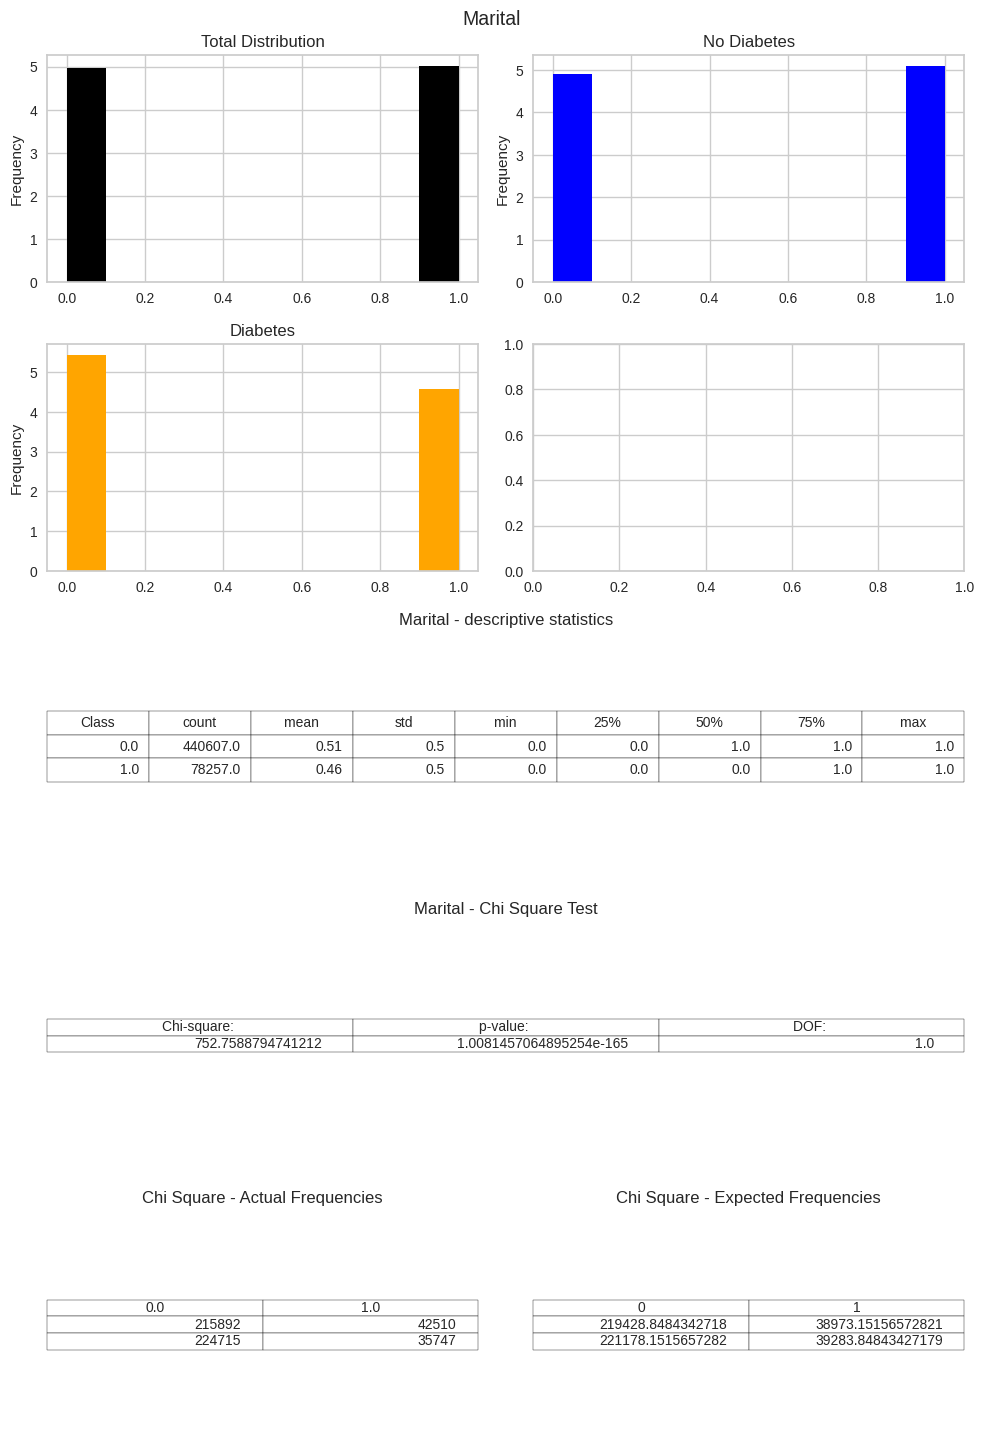

In [34]:
var_idx = var_idx + 1
var = var_list[var_idx]
fig = plt.figure()
var_hist(var, data, fig, 10,15)

## Collinearity & Variance

When using regression techniques, we make the statistical assumption that are predictors are independent, or not related. Thus, it is important that we drop any strongly intercorrelated features from our analysis. 

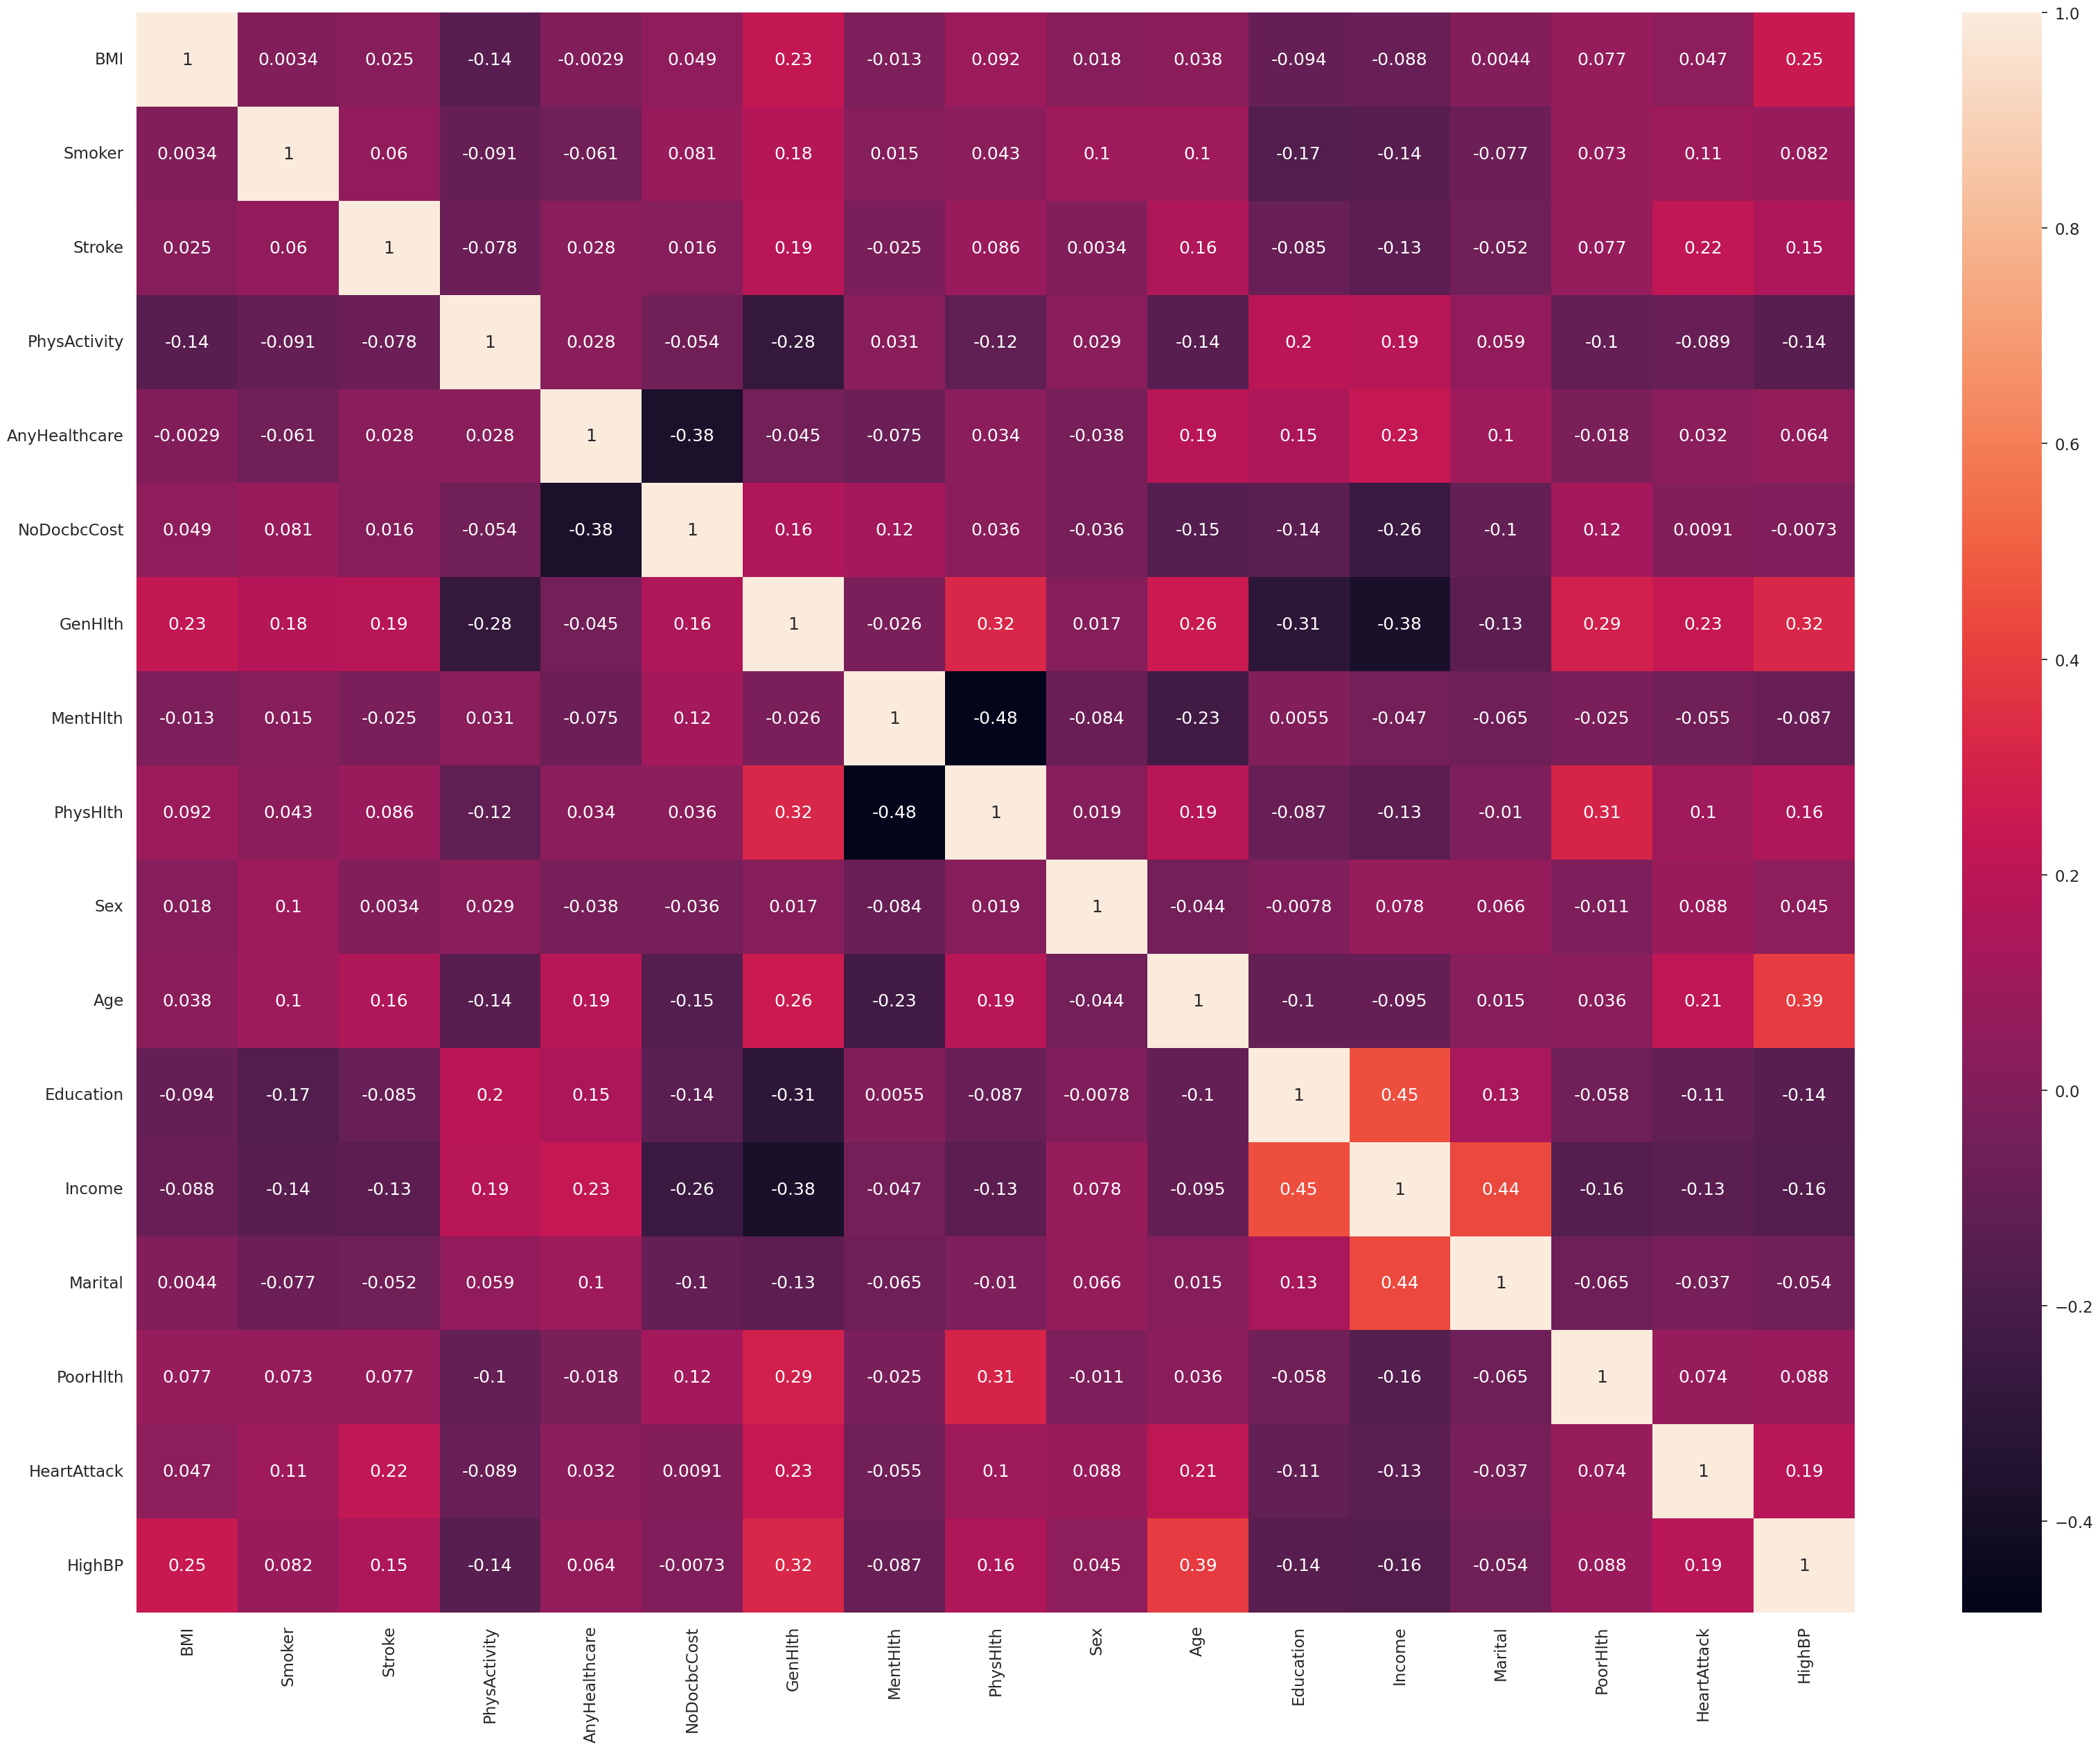

In [35]:
data_full = data
data_corr = data.drop(['Diabetes_012'],axis=1)
corrMatrix = data_corr.corr()
sn.set(rc={'figure.figsize':(40,30)})
sn.set(font_scale=1.5)
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there are actually not many values that are strongly intercorrelated. Usually a strong correlation is considered to be 0.70 or greater. However, there are some variables that are moderately intercorrelated.

In [36]:
def vif(data_corr):
    drop_cols = []
    vif_flag = False
    while(vif_flag == False):
        vif = pd.DataFrame()
        vif["features"] = data_corr.columns
        vif["vif_factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
        vif = vif.sort_values(by=['vif_factor'], ascending=False)
        top_vif = vif.iloc[0]
        top_vif_name = top_vif['features']
        if(top_vif.loc['vif_factor'] > 5):
            drop_cols.append(top_vif_name)
            print(top_vif_name, ':', top_vif['vif_factor'])
            data_corr = data_corr.drop([top_vif_name],axis=1)
            continue
        else:
            vif_flag = True
            return vif, drop_cols

In [37]:
data_corr = data.drop(['Diabetes_012'],axis=1)
vif, drop_cols = vif(data_corr)

vif

Education : 21.722533841672416
GenHlth : 10.334077722925642
AnyHealthcare : 9.941773651404839
Income : 7.290235383363422
Age : 5.760197672084346


,features,vif_factor
0,BMI,4.177498
6,PhysHlth,3.832436
3,PhysActivity,2.795539
5,MentHlth,2.589884
9,PoorHlth,2.044855
11,HighBP,1.975141
1,Smoker,1.948117
8,Marital,1.932028
7,Sex,1.638296
4,NoDocbcCost,1.259778


In [38]:
data = data.drop(columns=drop_cols)

We will drop variables one by one, starting with the highest VIF scores.

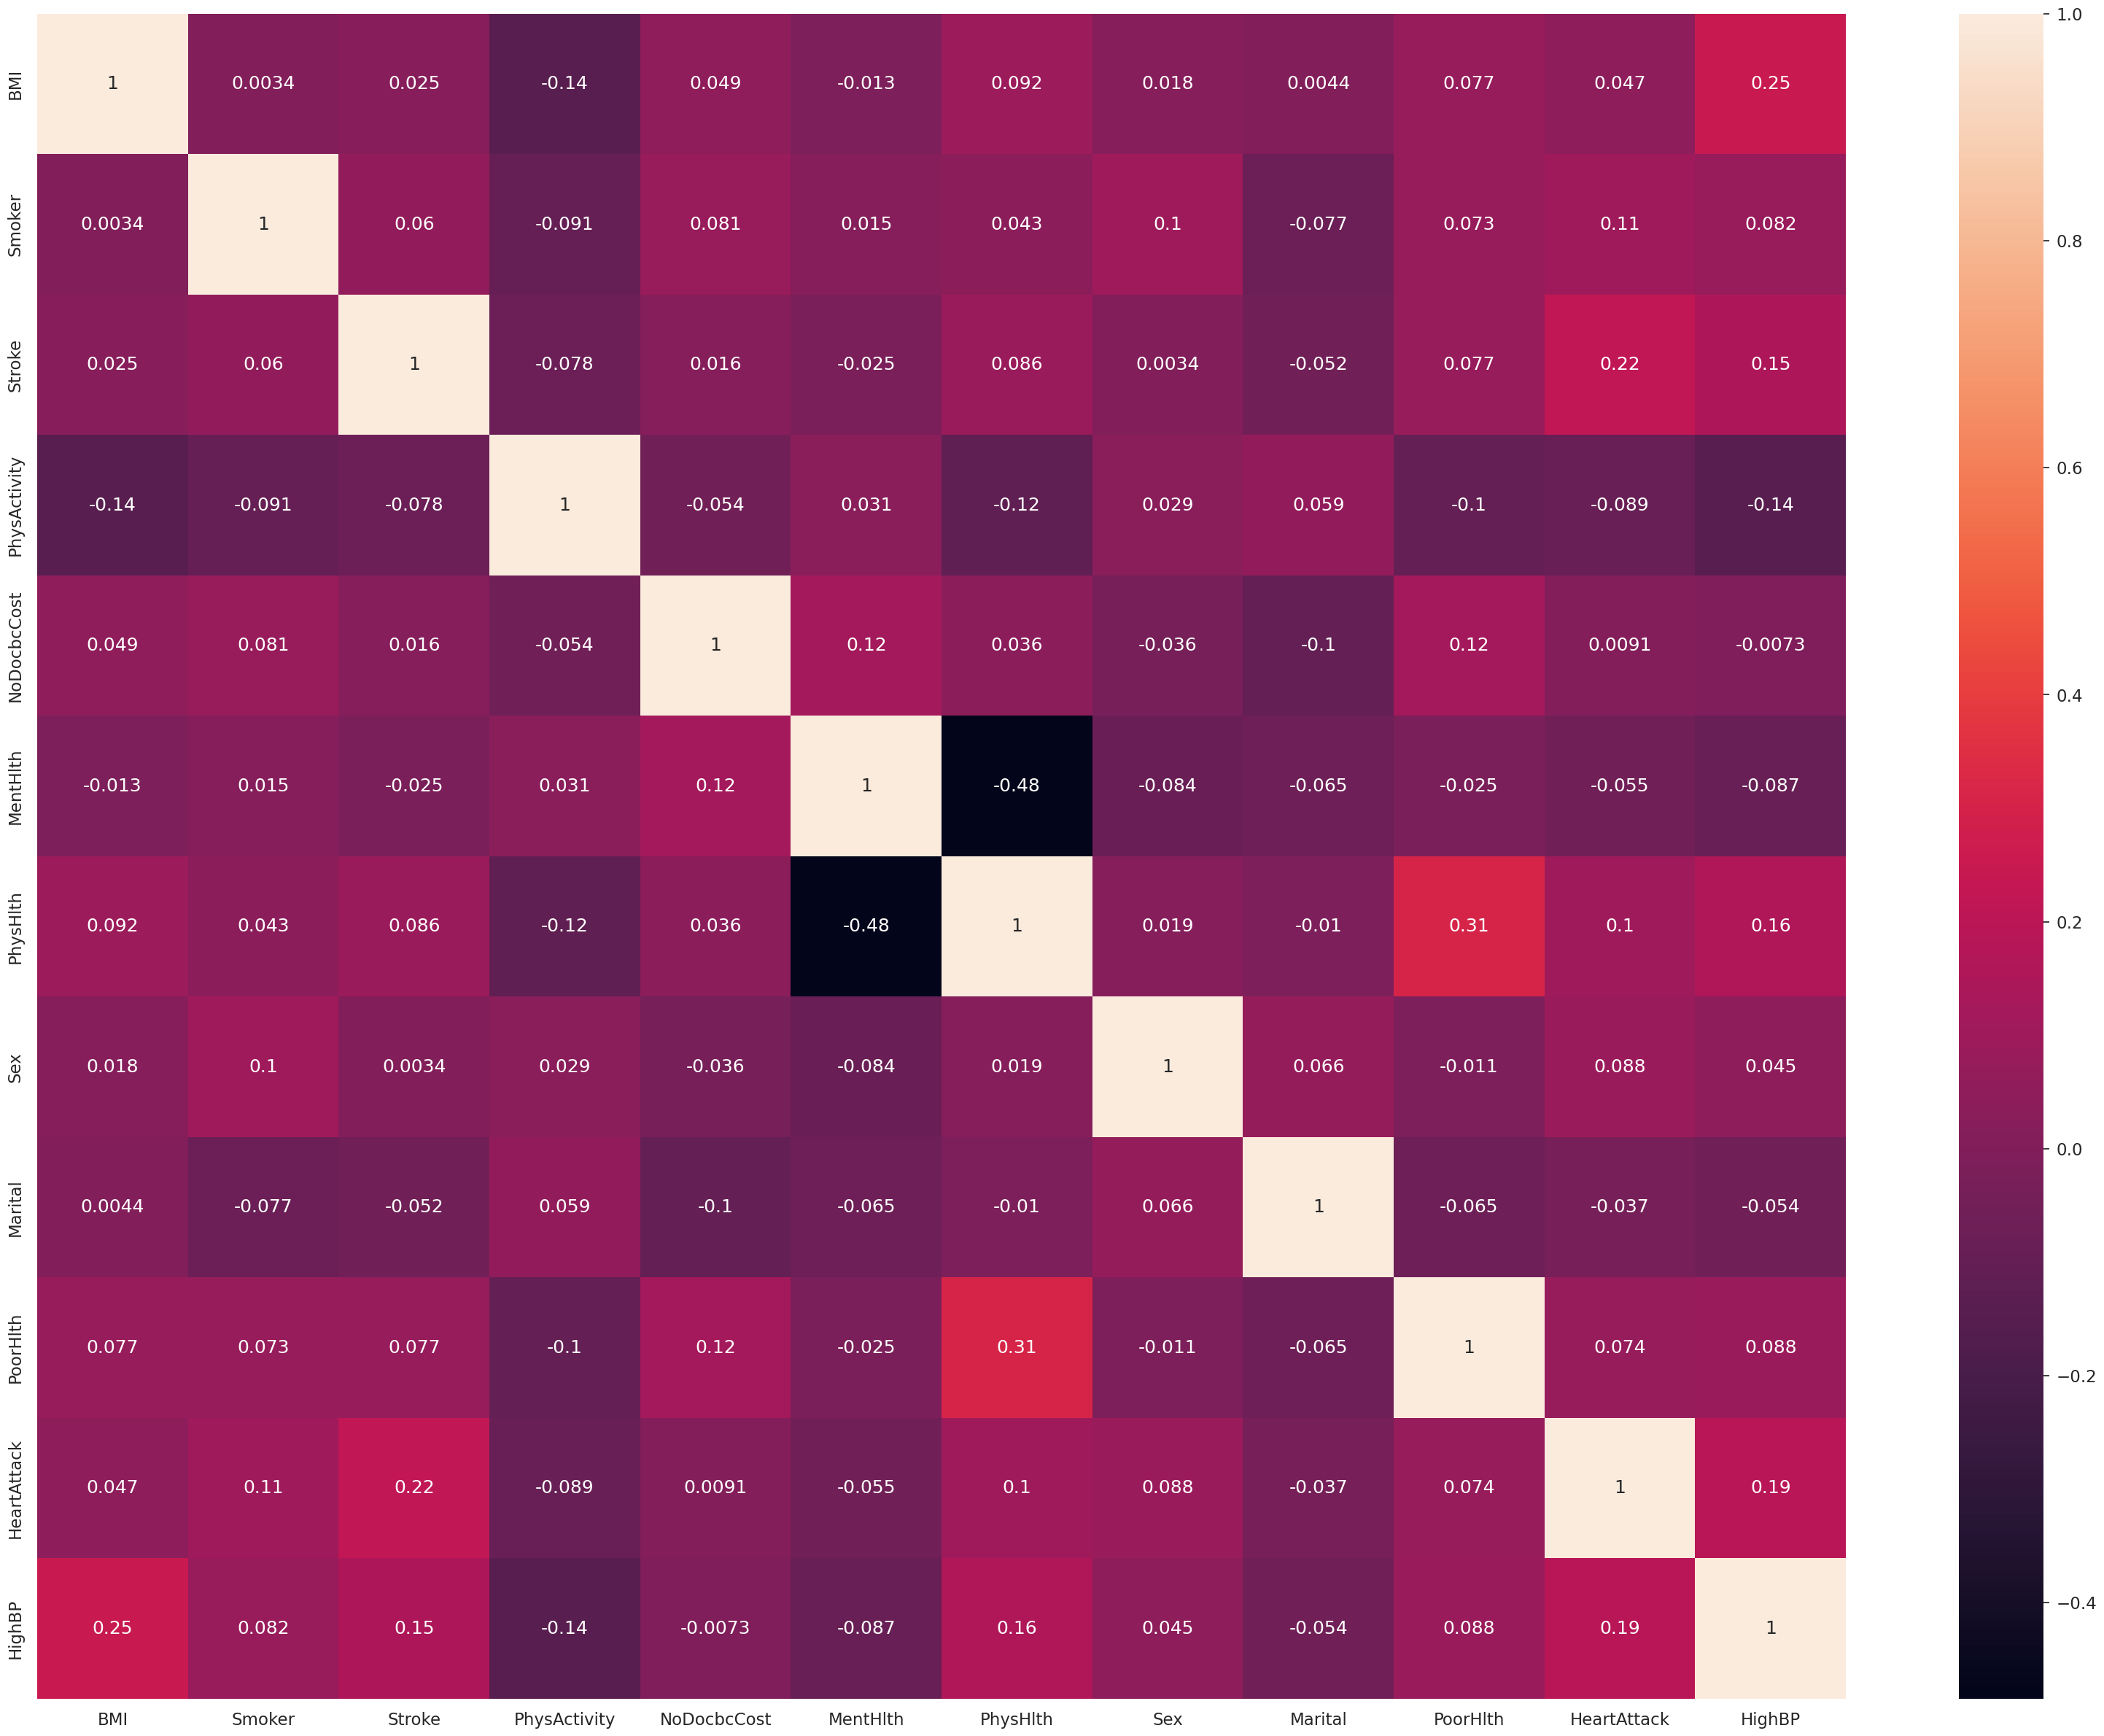

In [39]:
data_corr = data.drop(['Diabetes_012'],axis=1)
corrMatrix = data_corr.corr()
sn.set(rc={'figure.figsize':(40,30)})
sn.set(font_scale=1.5)
sn.heatmap(corrMatrix, annot=True)
plt.show()

We can see that there are still features that are moderately correlated. We will eliminate one of the features for each correlated pair to reduce collinearity. 

## Create training and testing data sets

In [40]:
y = data['Diabetes_012']
x = data.drop('Diabetes_012',axis=1)
print('Available Features',x.columns)
from sklearn.model_selection import train_test_split
x_tr_1, x_tst_1, y_tr_1, y_tst_1 = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y, random_state=0)

Available Features Index(['BMI', 'Smoker', 'Stroke', 'PhysActivity', 'NoDocbcCost', 'MentHlth',
       'PhysHlth', 'Sex', 'Marital', 'PoorHlth', 'HeartAttack', 'HighBP'],
      dtype='object')


## Initial Multinomial Logistic Regression Models

### Statsmodels 

In [41]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
x_tr_1_const = add_constant(x_tr_1)
print(Logit(y_tr_1, x_tr_1_const).fit().summary())

Optimization terminated successfully.
         Current function value: 0.349741
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Diabetes_012   No. Observations:               389148
Model:                          Logit   Df Residuals:                   389135
Method:                           MLE   Df Model:                           12
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                  0.1754
Time:                        21:51:53   Log-Likelihood:            -1.3610e+05
converged:                       True   LL-Null:                   -1.6505e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.0506      0.023   -173.630      0.000      -4.096      -4.005
BMI              0.4397

We can see that our model is doing an ok job, but could be improved. 
All of our p-values indicate that our predictors are statistically significant and related to our outcome.

In [42]:
x_tr_2, x_tst_2, y_tr_2, y_tst_2 = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y, random_state=1)
x_tr_2_const = add_constant(x_tr_2)
print(Logit(y_tr_2, x_tr_2_const).fit().summary())

Optimization terminated successfully.
         Current function value: 0.350029
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Diabetes_012   No. Observations:               389148
Model:                          Logit   Df Residuals:                   389135
Method:                           MLE   Df Model:                           12
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                  0.1747
Time:                        21:52:01   Log-Likelihood:            -1.3621e+05
converged:                       True   LL-Null:                   -1.6505e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -4.0513      0.023   -173.755      0.000      -4.097      -4.006
BMI              0.4425

Both models are performing about the same.
However, we have a lot of attributes, and will need to try other approaches and methods to see whether we can drop some of them or use other approaches to improve performance.


In [43]:
y_new = data['Diabetes_012']
x_new = data.drop('Diabetes_012',axis=1)

In [44]:
x_tr_sk, x_tst_sk, y_tr_sk, y_tst_sk = train_test_split(x_new,y_new,test_size = 0.25, shuffle=True, stratify=y,random_state=0)

In [45]:
from sklearn.linear_model import LogisticRegression
logit_1 = LogisticRegression(max_iter = 2500, class_weight='balanced')
logit_1.fit(x_tr_sk,y_tr_sk)
y_pred_1 = logit_1.predict(x_tst_sk)
y_true_1 = y_tst_sk

coefficients = pd.concat([pd.DataFrame(x_tr_sk.columns),pd.DataFrame(np.transpose(logit_1.coef_))], axis = 1)
print(coefficients)

               0         0
0            BMI  0.459050
1         Smoker  0.101777
2         Stroke  0.587435
3   PhysActivity -0.311530
4    NoDocbcCost -0.089581
5       MentHlth -0.049253
6       PhysHlth  0.587826
7            Sex  0.071636
8        Marital -0.125348
9       PoorHlth  0.133128
10   HeartAttack  0.858411
11        HighBP  1.372602


Training accuracy:
0.71
Test accuracy:
0.71
Recall Score:
0.71
Precision Score:
0.84


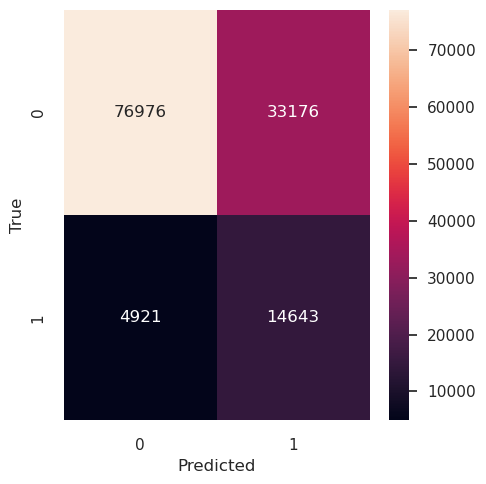

In [46]:
from sklearn.metrics import accuracy_score, recall_score, precision_score
print("Training accuracy:")
print(np.round(accuracy_score(y_tr_sk,logit_1.predict(x_tr_sk)),2))
print("Test accuracy:")
print(np.round(accuracy_score(y_true_1,y_pred_1),2))
print("Recall Score:")
print(np.round(recall_score(y_true_1, y_pred_1,average='weighted'),2))
print("Precision Score:")
print(np.round(precision_score(y_true_1, y_pred_1,average='weighted'),2))

from sklearn.metrics import confusion_matrix
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(y_true_1,y_pred_1)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


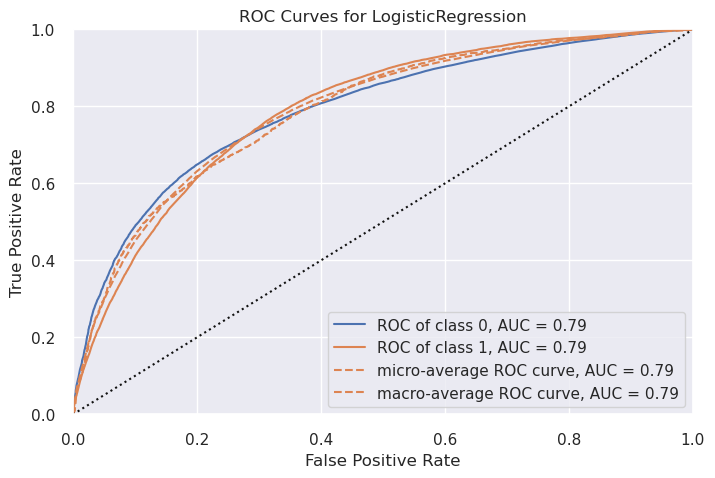

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [47]:
from yellowbrick.classifier import ROCAUC
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(logit_1,classes=[0,1])
visualizer.fit(x_tr_sk, y_tr_sk)
visualizer.score(x_tst_sk, y_tst_sk) 
visualizer.show() 

The model is performing similarly for both classes, but could be improved. 


In [48]:
from sklearn.feature_selection import RFE
data.head
x_rfe = data.drop(columns=['Diabetes_012'])
y_rfe = data['Diabetes_012']
train_x_rfe, test_x_rfe, train_y_rfe, test_y_rfe = train_test_split(x_rfe, y_rfe, test_size = 0.25, shuffle=True, stratify=y, random_state=0)
logit_rfe = LogisticRegression(max_iter=4000,class_weight='balanced')


In [49]:
rfe = RFE(logit_rfe,n_features_to_select=5, step=1)
fit = rfe.fit(train_x_rfe,train_y_rfe)

In [50]:
col = x_rfe.columns
RFE_sup = rfe.support_
RFE_rank = rfe.ranking_
dataset = pd.DataFrame({'Columns': col, 'RFE_support': RFE_sup, 'RFE_ranking': RFE_rank}, columns=['Columns', 'RFE_support', 'RFE_ranking'])
df = dataset[(dataset["RFE_support"] == True) & (dataset["RFE_ranking"] == 1)]
filtered_features = df['Columns']
filtered_features

0             BMI
2          Stroke
6        PhysHlth
10    HeartAttack
11         HighBP
Name: Columns, dtype: object

In [51]:
new_train_x_rfe = train_x_rfe[filtered_features]
new_test_x_rfe = test_x_rfe[filtered_features]

In [52]:
new_train_x_rfe_const = add_constant(new_train_x_rfe)
model = Logit(train_y_rfe, new_train_x_rfe_const).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.351347
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:           Diabetes_012   No. Observations:               389148
Model:                          Logit   Df Residuals:                   389142
Method:                           MLE   Df Model:                            5
Date:                Thu, 10 Aug 2023   Pseudo R-squ.:                  0.1716
Time:                        21:52:38   Log-Likelihood:            -1.3673e+05
converged:                       True   LL-Null:                   -1.6505e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -4.3188      0.017   -252.938      0.000      -4.352      -4.285
BMI             0.4497    

In [53]:
logit_rfe = LogisticRegression(max_iter = 2500,solver='newton-cg', class_weight='balanced')
logit_rfe.fit(new_train_x_rfe,train_y_rfe)
y_pred_rfe = logit_rfe.predict(new_test_x_rfe)
y_true_rfe = test_y_rfe

coefficients = pd.concat([pd.DataFrame(new_train_x_rfe.columns),pd.DataFrame(np.transpose(logit_rfe.coef_))], axis = 1)
print(coefficients)

             0         0
0          BMI  0.468971
1       Stroke  0.636388
2     PhysHlth  0.686717
3  HeartAttack  0.917958
4       HighBP  1.403635


Training accuracy:
0.72
Test accuracy:
0.72
Recall Score:
0.72
Precision Score:
0.84


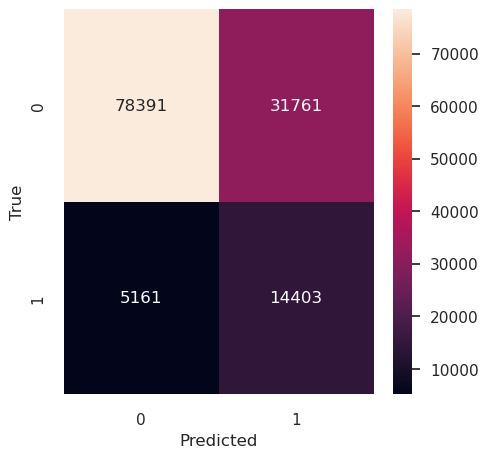

In [54]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(test_y_rfe,y_pred_rfe)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_rfe,logit_rfe.predict(new_train_x_rfe)),2))
print("Test accuracy:")
print(np.round(accuracy_score(test_y_rfe,y_pred_rfe),2))
print("Recall Score:")
print(np.round(recall_score(test_y_rfe, y_pred_rfe,average='weighted'),2))
print("Precision Score:")
print(np.round(precision_score(test_y_rfe, y_pred_rfe,average='weighted'),2))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


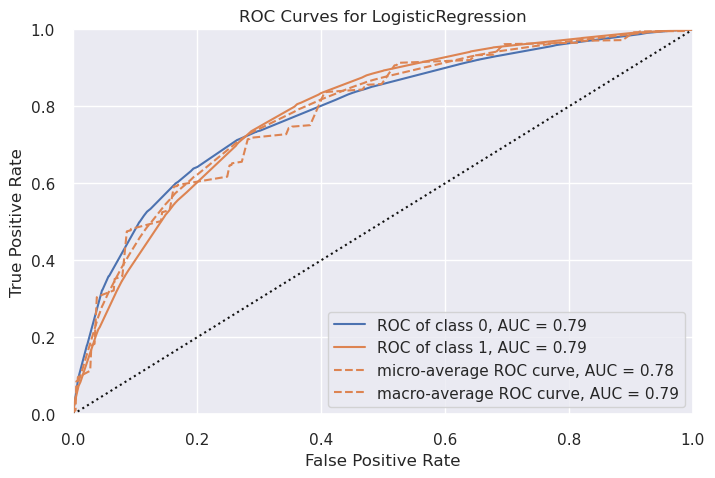

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [55]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(logit_rfe,classes=[0,1])
visualizer.fit(new_train_x_rfe, train_y_rfe)
visualizer.score(new_test_x_rfe, test_y_rfe) 
visualizer.show() 

In [56]:
data = data[['Diabetes_012','BMI','Stroke','PhysHlth','HeartAttack','HighBP']]

In [57]:
y = data['Diabetes_012']
x = data.drop('Diabetes_012',axis=1)

x_tr, x_tst, y_tr, y_tst = train_test_split(x,y,test_size = 0.25, shuffle=True, stratify=y,random_state=0)

In [58]:
import imblearn
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
counter = Counter(y_tr)
print(counter)
over = SMOTE(sampling_strategy={1:100000},random_state=12 )
#under = RandomUnderSampler(sampling_strategy={0: 6000,2:6000})
steps = [('o', over)]
#steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
trainX_sm ,trainY_sm = pipeline.fit_resample(x_tr, y_tr)

columns_x = x_tr.columns

train_x_smote = pd.DataFrame(data=trainX_sm,columns=columns_x)
train_y_smote = pd.DataFrame(data=trainY_sm,columns=['Diabetes_012'])

counter = Counter(trainY_sm)
print(counter)

Counter({0.0: 330455, 1.0: 58693})
Counter({0.0: 330455, 1.0: 100000})


In [59]:
logit_sm = LogisticRegression(solver='newton-cg',max_iter = 2500, class_weight='balanced' )
logit_sm.fit(train_x_smote, train_y_smote.values.ravel())

y_pr_sm = logit_sm.predict(x_tst)
coefficients = pd.concat([pd.DataFrame(train_x_smote.columns),pd.DataFrame(np.transpose(logit_sm.coef_))], axis = 1)
print(coefficients)

             0         0
0          BMI  0.466484
1       Stroke  0.623183
2     PhysHlth  0.699538
3  HeartAttack  0.917660
4       HighBP  1.402671


Training accuracy:
0.72
Test accuracy:
0.72
Recall Score:
0.72
Precision Score:
0.84


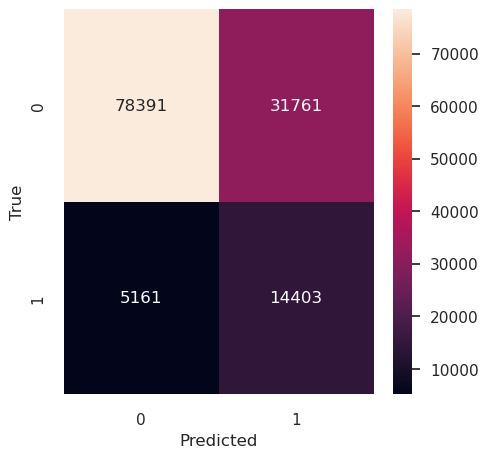

In [60]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(y_tst,y_pr_sm)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_smote,logit_sm.predict(train_x_smote)),2))
print("Test accuracy:")
print(np.round(accuracy_score(y_tst,y_pr_sm),2))
print("Recall Score:")
print(np.round(recall_score(y_tst, y_pr_sm, average='weighted'),2))
print("Precision Score:")
print(np.round(precision_score(y_tst, y_pr_sm, average='weighted'),2))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


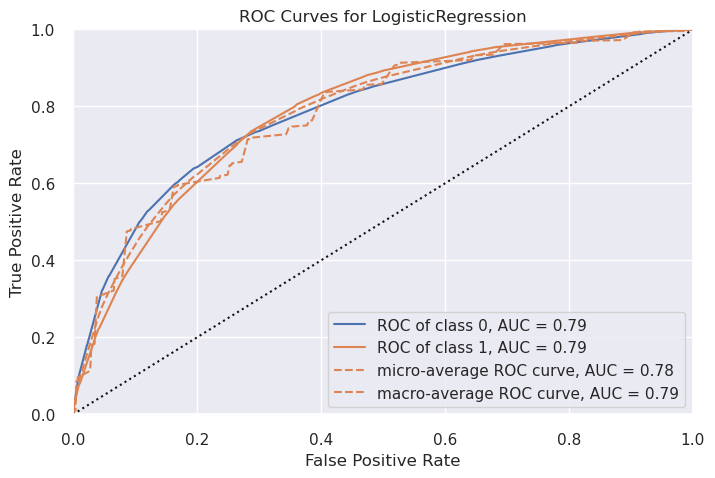

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [61]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(logit_sm,classes=[0,1])
visualizer.fit(train_x_smote, train_y_smote)
visualizer.score(x_tst, y_tst)
visualizer.show() 

In [62]:
counter = Counter(y_tr)
print(counter)
over = SMOTE(sampling_strategy={1:100000},random_state=12 )
under = RandomUnderSampler(sampling_strategy={0: 100000})
#steps = [('o', over)]
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
trainX_sm_un,trainY_sm_un = pipeline.fit_resample(x_tr, y_tr)

columns_x = x_tr.columns

train_x_smote_under = pd.DataFrame(data=trainX_sm_un,columns=columns_x)
train_y_smote_under = pd.DataFrame(data=trainY_sm_un,columns=['Diabetes_012'])

counter = Counter(trainY_sm_un)
print(counter)

Counter({0.0: 330455, 1.0: 58693})
Counter({0.0: 100000, 1.0: 100000})


In [63]:
logit_sm_un = LogisticRegression(max_iter=2500,solver='newton-cg')
logit_sm_un.fit(train_x_smote_under, train_y_smote_under.values.ravel())

y_pr_sm_un = logit_sm_un.predict(x_tst)
coefficients = pd.concat([pd.DataFrame(train_x_smote_under.columns),pd.DataFrame(np.transpose(logit_sm_un.coef_))], axis = 1)
print(coefficients)

             0         0
0          BMI  0.463367
1       Stroke  0.616386
2     PhysHlth  0.709139
3  HeartAttack  0.927726
4       HighBP  1.404675


Training accuracy:
0.72
Test accuracy:
0.72
Recall Score:
0.72
Precision Score:
0.84


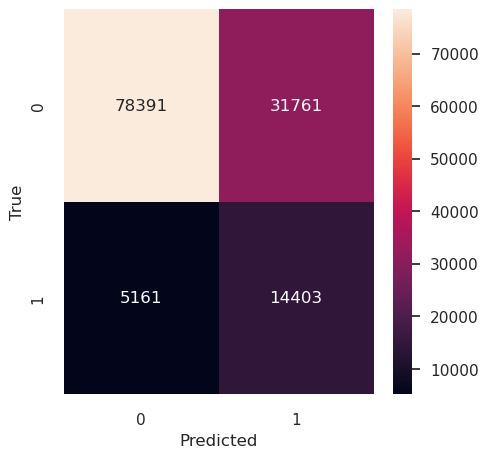

In [64]:
sn.set(rc={'figure.figsize':(5,5)})
sn.set(font_scale=1)
matrix = confusion_matrix(y_tst,y_pr_sm)
sn.heatmap(matrix,annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
print("Training accuracy:")
print(np.round(accuracy_score(train_y_smote_under,logit_sm_un.predict(train_x_smote_under)),2))
print("Test accuracy:")
print(np.round(accuracy_score(y_tst_sk,y_pr_sm_un),2))
print("Recall Score:")
print(np.round(recall_score(y_tst, y_pr_sm_un, average='weighted',zero_division=0),2))
print("Precision Score:")
print(np.round(precision_score(y_tst, y_pr_sm_un, average='weighted',zero_division=0),2))

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:409: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


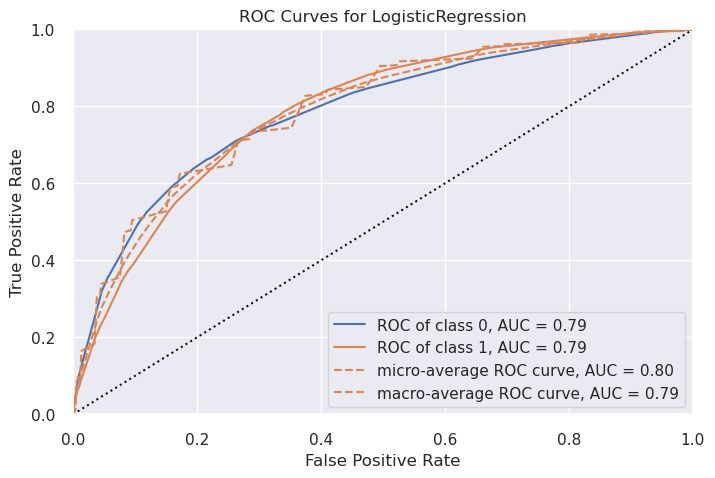

<AxesSubplot: title={'center': 'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [65]:
sn.set(rc={'figure.figsize':(8,5)})
visualizer = ROCAUC(logit_sm_un,classes=[0,1])
visualizer.fit(train_x_smote_under, train_y_smote_under)
visualizer.score(x_tst, y_tst) 
visualizer.show() 

### Principal Component Analysis

In [66]:
from sklearn.preprocessing import StandardScaler

y_sc = data['Diabetes_012']
x_sc = data.drop('Diabetes_012',axis=1)

scaler = StandardScaler()
x_tr = scaler.fit_transform(x_sc)


In [67]:
from sklearn.decomposition import PCA
pca = PCA(n_components = None)
pca.fit(x_tr)

PCA()

In [68]:
print('Variance Explained - %')
print(pca.explained_variance_ratio_ * 100)


Variance Explained - %
[30.97252515 21.22430926 18.15396588 15.56860722 14.0805925 ]


Text(0, 0.5, 'explained variance')

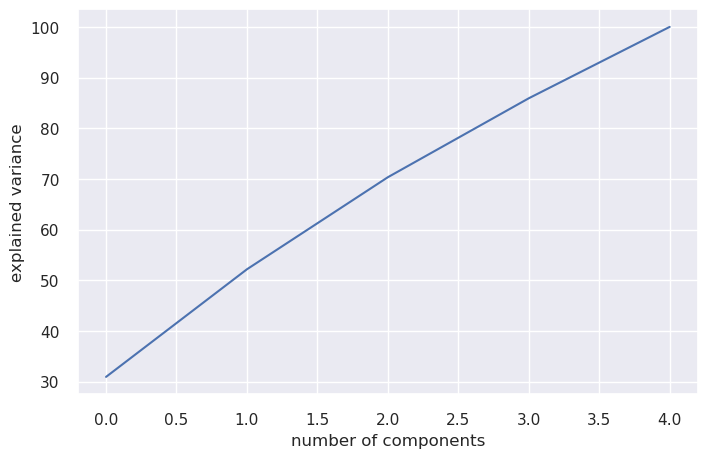

In [69]:
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('number of components')
plt.ylabel('explained variance')

Unfortunately we can see that each of the included variables only explains a small portion of the variance in the outcome.